In [1]:
### Import package

## Data Understanding

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
from scipy import stats

%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
### Generate data

In [5]:
import yfinance as yf

from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [6]:
pd.set_option('display.max_colwidth', None)

In [7]:
directory_to_img = os.path.join('..', '..', 'images')

In [8]:
### Apply date and company MLBI.JK

In [9]:
start = datetime(2014, 1, 1)
end = datetime(2020,3,18)

tckr = 'DVLA.JK'

In [10]:
### Plot closing price

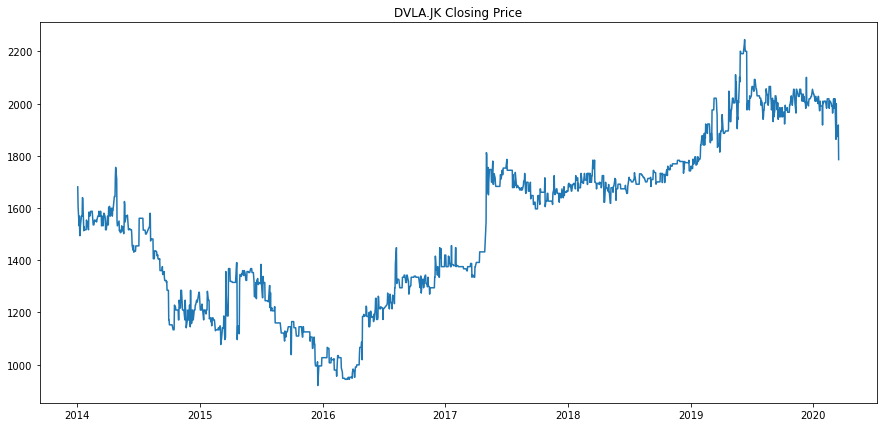

In [11]:
ticker = yf.Ticker(tckr)

plt.figure(figsize=(15,7))
df = ticker.history(start=start, 
                    end=end, 
                    interval="1d")
plt.title('DVLA.JK Closing Price')

plt.plot(df.Close)
plt.savefig(os.path.join('close_DVLAJK.jpg'), dpi=300, bbox_inches='tight');

CLOSING PRICE cenderung naik trend nya

### Types of Volatility and How They are Measured
(Source: https://www.investopedia.com/terms/v/vix.asp)

Volatility does not measure the direction of price changes of a financial instrument, merely its dispersions over a certain period of time. The more dramatic the price swings are in that instrument, the higher the level of volatility, and vice versa. High volatility is associated with higher risk, and low volatility low risk.

Volatility can either be historical or implied; both are usually expressed in percentage terms.

Historical Volatility (HV) or Realized Volatility is the actual volatility demonstrated by the underlying over a period of time. Realized Volatility is commonly calculated as the standard deviation of price returns, which is the dollar change in price as a percentage of previous day's price.
Implied volatility (IV), on the other hand, is the level of volatility of the underlying that is implied by the current option price.
(The main focus of this project is NOT implied volatility, which traditionally can be derived from option pricing models such as the Black Scholes Model).

In [12]:
# CALCULATE PRICE RETURNS AS DAILY PERCENTAGE CHANGE USING pct_change()
df['returns'] = 100 * df.Close.pct_change().dropna()

Further research indicates that for practicality purposes it's preferable to use the log returns especially in mathematic modeling, because it helps eliminate non-stationary properties of time series data, and makes it more stable:

LOG RETURNS FORMULA:


There's another advantage to log returns, which is that they're additive across time: 


In [13]:
# CALCULATE LOG RETURNS BASED ON ABOVE FORMULA
df['log_returns'] = np.log(df.Close/df.Close.shift(1))

In [14]:
### df shift itu row itu dikurang row atasny dibagi row atasnya

In [15]:
df.head()

Open         High          Low        Close  Volume  \
Date                                                                     
2014-01-02  1643.852604  1681.212891  1643.852604  1681.212891   25000   
2014-01-03  1606.492432  1606.492432  1606.492432  1606.492432    5000   
2014-01-06  1531.771973  1531.771973  1531.771973  1531.771973     600   
2014-01-07  1494.411505  1569.132080  1494.411505  1569.132080    1400   
2014-01-08  1494.411621  1494.411621  1494.411621  1494.411621     200   

            Dividends  Stock Splits   returns  log_returns  
Date                                                        
2014-01-02        0.0             0       NaN          NaN  
2014-01-03        0.0             0 -4.444438    -0.045462  
2014-01-06        0.0             0 -4.651155    -0.047628  
2014-01-07        0.0             0  2.439012     0.024097  
2014-01-08        0.0             0 -4.761897    -0.048790

In [16]:
# DROPPING THE 1ST ROW OF DATA 
# BECAUSE I SHIFTED IT FORWARD TO CALCULATE RETURNS/LOG RETURNS
df.dropna(inplace=True)

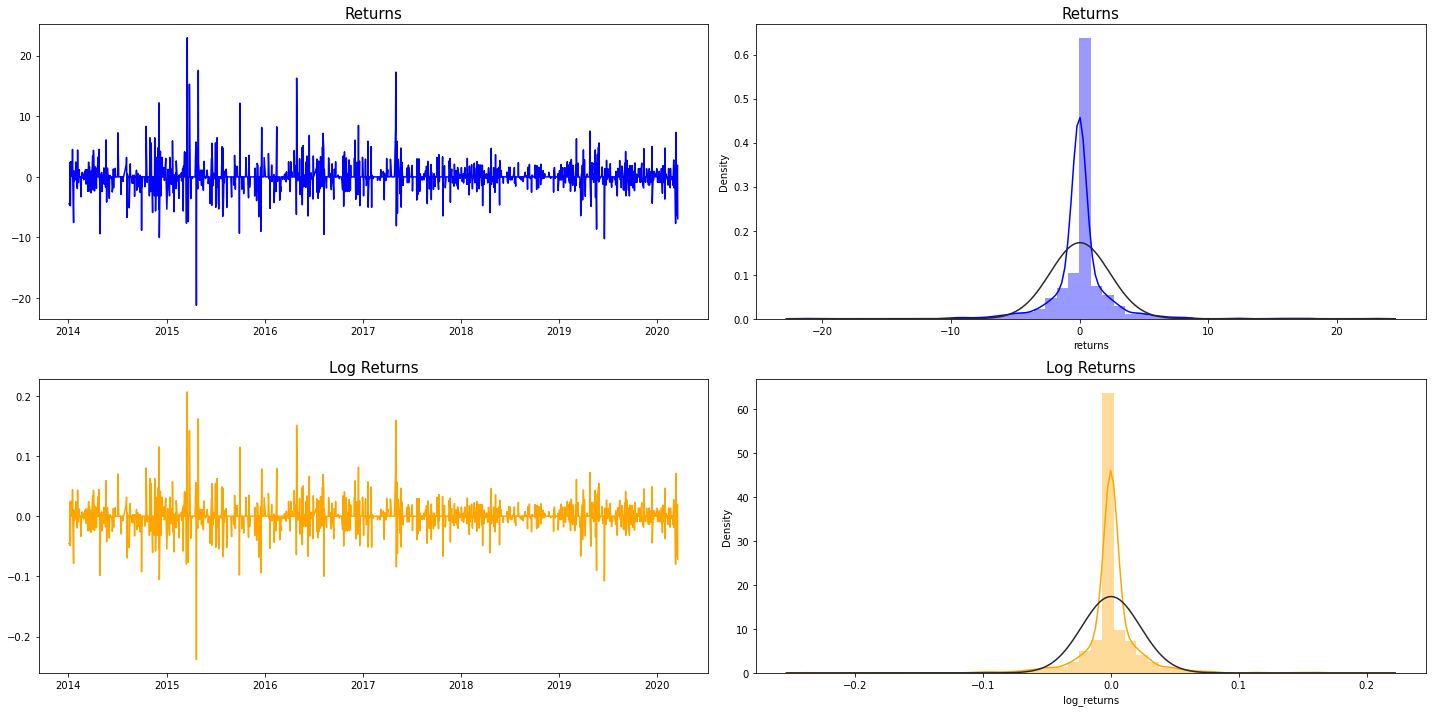

In [17]:
# PLOT DISTRIBUTION PLOTS OF RETURNS & LOG RETURNS
# AND VISUALLY COMPARE THEM WITH THE STANDARD NORMAL DISTRIBUTION
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,10))

axes[0][0].plot(df.returns, color='blue')
axes[0][0].set_title('Returns', fontsize=15)

sns.distplot(df.returns, norm_hist=True, fit=stats.norm, color='blue',
             bins=50, ax=axes[0][1])
axes[0][1].set_title('Returns', fontsize=15)

axes[1][0].plot(df.log_returns, color='orange')
axes[1][0].set_title('Log Returns', fontsize=15)

sns.distplot(df.log_returns, norm_hist=True, fit=stats.norm, color='orange',
             bins=50, ax=axes[1][1])
axes[1][1].set_title('Log Returns', fontsize=15)
plt.tight_layout()
plt.savefig(os.path.join('returns_logreturns.jpg'), dpi=300, bbox_inches='tight')
fig.show();

In [18]:
df.returns.describe()

count    1560.000000
mean        0.030222
std         2.307420
min       -21.195648
25%        -0.253480
50%         0.000000
75%         0.000000
max        22.945214
Name: returns, dtype: float64

In [19]:
df.log_returns.describe()

count    1560.000000
mean        0.000039
std         0.022935
min        -0.238202
25%        -0.002538
50%         0.000000
75%         0.000000
max         0.206569
Name: log_returns, dtype: float64

In [20]:
# CREATE A FUNCTION THAT CALCULATE REALIZED VOLATILITY
# FROM DAILY LOG RETURNS
def realized_volatility_daily(series_log_return):
    """
    Get the daily realized volatility which is calculated as the square root
    of sum of squares of log returns within a specific window interval 
    """
    n = len(series_log_return)
    return np.sqrt(np.sum(series_log_return**2)/(n - 1))

The goal here is to forecast the average realized volatility of the next n_future 7 days using a number of immediate past/historical datapoints (n_past).

In [21]:
intervals = [7, 30, 60, 180, 365]
vols_df = {}

# ITERATE OVER intervals LIST
for i in intervals:
    # GET DAILY LOG RETURNS USING THAT INTERVAL
    vols = df.log_returns.rolling(window=i)\
                         .apply(realized_volatility_daily).values

    vols_df[i] = vols

# CONVERT vols_df FROM DICTIONARY TO PANDAS DATAFRAME
vols_df = pd.DataFrame(vols_df, columns=intervals, index=df.index)

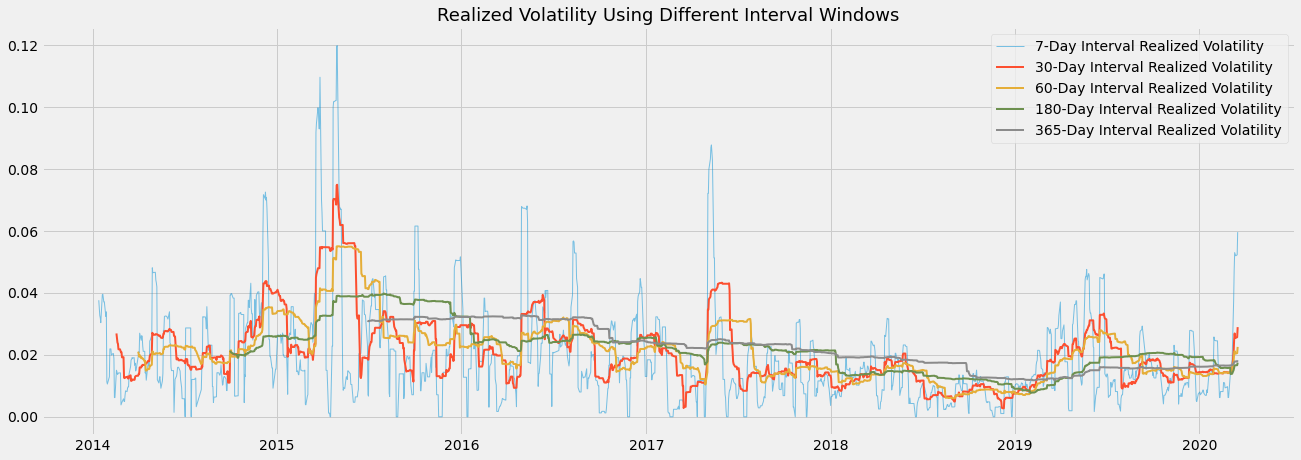

In [22]:
# CHANGING MATPLOTLIB STYLE
plt.style.use(['fivethirtyeight'])

fig, ax = plt.subplots(figsize=(20,7))

for i in intervals:
    if i == 7:
        alpha = 0.5
        lw = 1
    else:
        alpha = 1.0
        lw = 2
    ax.plot(vols_df[i], label=f'{i}-Day Interval Realized Volatility', 
            alpha=alpha, lw=lw)

ax.set_title('Realized Volatility Using Different Interval Windows', fontsize=18)

plt.legend(loc='best', prop={'size': 14})
plt.savefig(os.path.join('diff_intervals.jpg'), dpi=300, bbox_inches='tight')
plt.show();

In [23]:
## VOLATILITY nya lumayan fluctuative

The reason I selected 30 days is because 7 days seems too noisy to observe meaningful patterns, while longer intervals seem to smooth the volatility down significantly and tend to mean-revert.

Using interval window of 30 days would also help avoid wasting too many datapoints at the beginning of the dataset.

In [24]:
### hrsny the more frequent the more accurate (law of large number), tapi kl 7 days tuh trlalu noisy makanya dia pilih 30 days

In [25]:
INTERVAL_WINDOW = 30
n_future = 7

# GET BACKWARD LOOKING REALIZED VOLATILITY
df['vol_current'] = df.log_returns.rolling(window=INTERVAL_WINDOW)\
                                   .apply(realized_volatility_daily)

# GET FORWARD LOOKING REALIZED VOLATILITY 
df['vol_future'] = df.log_returns.shift(-n_future)\
                                 .rolling(window=INTERVAL_WINDOW)\
                                 .apply(realized_volatility_daily)

In [26]:
df.describe()

Open         High          Low        Close         Volume  \
count  1560.000000  1560.000000  1560.000000  1560.000000    1560.000000   
mean   1535.356411  1547.892851  1524.061416  1537.637696   13622.251282   
std     312.792824   317.628854   308.359041   312.076901   43237.443321   
min     920.251160   920.251160   916.301410   920.251160       0.000000   
25%    1278.400841  1294.583130  1259.583198  1284.973511       0.000000   
50%    1569.132217  1587.812378  1561.262582  1569.132080    1200.000000   
75%    1744.407440  1747.122589  1731.062866  1744.798828    9625.000000   
max    2236.435324  2398.105454  2200.509033  2245.416992  799100.000000   

         Dividends  Stock Splits      returns  log_returns  vol_current  \
count  1560.000000        1560.0  1560.000000  1560.000000  1531.000000   
mean      0.282692           0.0     0.030222     0.000039     0.020264   
std       3.762713           0.0     2.307420     0.022935     0.011002   
min       0.000000           0.0   -21.195648    -0.238202     0.002717   
25%       0.000000           0.0    -0.253480    -0.002538     0.012973   
50%       0.000000           0.0     0.000000     0.000000     0.017999   
75%       0.000000           0.0     0.000000     0.000000     0.025913   
max      70.000000           0.0    22.945214     0.206569     0.074889   

        vol_future  
count  1524.000000  
mean      0.020249  
std       0.011024  
min       0.002717  
25%       0.012968  
50%       0.017948  
75%       0.025933  
max       0.074889

In [27]:
df = df.drop(['Dividends', 'Stock Splits'], axis=1)

In [28]:
df.describe()

Open         High          Low        Close         Volume  \
count  1560.000000  1560.000000  1560.000000  1560.000000    1560.000000   
mean   1535.356411  1547.892851  1524.061416  1537.637696   13622.251282   
std     312.792824   317.628854   308.359041   312.076901   43237.443321   
min     920.251160   920.251160   916.301410   920.251160       0.000000   
25%    1278.400841  1294.583130  1259.583198  1284.973511       0.000000   
50%    1569.132217  1587.812378  1561.262582  1569.132080    1200.000000   
75%    1744.407440  1747.122589  1731.062866  1744.798828    9625.000000   
max    2236.435324  2398.105454  2200.509033  2245.416992  799100.000000   

           returns  log_returns  vol_current   vol_future  
count  1560.000000  1560.000000  1531.000000  1524.000000  
mean      0.030222     0.000039     0.020264     0.020249  
std       2.307420     0.022935     0.011002     0.011024  
min     -21.195648    -0.238202     0.002717     0.002717  
25%      -0.253480    -0.002538     0.012973     0.012968  
50%       0.000000     0.000000     0.017999     0.017948  
75%       0.000000     0.000000     0.025913     0.025933  
max      22.945214     0.206569     0.074889     0.074889

Since I am currently using aN INTERVAL_WINDOW of 30 and a horizon n_future of 7, the volatilty of first 30 values as well as the last 7 values of the dataframe would be NaN, and therefore need to be dropped from the dataset.

In [29]:
### ini knp yg first 30 values nan ya krn kan dibagi volatility ny per 30 days. jd sebelum per 30 days itu gada nilainya. sdgkan last 7 values jg gada krn gada di interval

In [30]:
# DROPPING ALL NaN VALUES
df.dropna(inplace=True)

In [31]:
df

Open         High          Low        Close  Volume  \
Date                                                                     
2014-02-17  1554.188080  1569.132196  1494.411615  1535.507935   66700   
2014-02-18  1606.492486  1606.492486  1535.507935  1535.507935    6500   
2014-02-19  1587.812341  1587.812341  1535.507935  1535.507935    7000   
2014-02-20  1539.243951  1542.979980  1539.243951  1542.979980    1200   
2014-02-21  1546.716174  1554.188232  1546.716174  1554.188232     900   
...                 ...          ...          ...          ...     ...   
2020-03-02  2055.127271  2055.127271  1963.788281  2018.591675   33100   
2020-03-03  2018.591874  2036.859674  1982.056274  1982.056274    4800   
2020-03-04  1991.189978  2018.591675  1991.189978  2018.591675   44700   
2020-03-05  2027.725661  2082.529057  1991.190063  1991.190063   89700   
2020-03-06  1991.189978  2018.591675  1991.189978  2018.591675    5500   

             returns  log_returns  vol_current  vol_future  
Date                                                        
2014-02-17 -3.294120    -0.033496     0.026888    0.020817  
2014-02-18  0.000000     0.000000     0.025528    0.020836  
2014-02-19  0.000000     0.000000     0.023947    0.019169  
2014-02-20  0.486617     0.004854     0.023543    0.019246  
2014-02-21  0.726403     0.007238     0.021771    0.012603  
...              ...          ...          ...         ...  
2020-03-02  2.790689     0.027525     0.014304    0.026885  
2020-03-03 -1.809945    -0.018265     0.014701    0.025476  
2020-03-04  1.843308     0.018265     0.014697    0.025461  
2020-03-05 -1.357462    -0.013668     0.014818    0.025697  
2020-03-06  1.376142     0.013668     0.015034    0.028928  

[1524 rows x 9 columns]

In [32]:
df.describe()

Open         High          Low        Close         Volume  \
count  1524.000000  1524.000000  1524.000000  1524.000000    1524.000000   
mean   1533.064252  1545.590395  1522.081052  1535.653340   13391.215223   
std     315.042917   320.039793   310.989958   314.768737   42654.654849   
min     920.251160   920.251160   916.301410   920.251160       0.000000   
25%    1262.218495  1292.560288  1251.407447  1277.065277       0.000000   
50%    1569.132187  1589.680325  1561.262582  1569.132080    1200.000000   
75%    1744.798828  1747.687012  1731.062877  1744.798828    9600.000000   
max    2236.435324  2398.105454  2200.509033  2245.416992  799100.000000   

           returns  log_returns  vol_current   vol_future  
count  1524.000000  1524.000000  1524.000000  1524.000000  
mean      0.041395     0.000158     0.020240     0.020249  
std       2.277590     0.022614     0.011020     0.011024  
min     -21.195648    -0.238202     0.002717     0.002717  
25%      -0.252522    -0.002528     0.012968     0.012968  
50%       0.000000     0.000000     0.017948     0.017948  
75%       0.000000     0.000000     0.025904     0.025933  
max      22.945214     0.206569     0.074889     0.074889

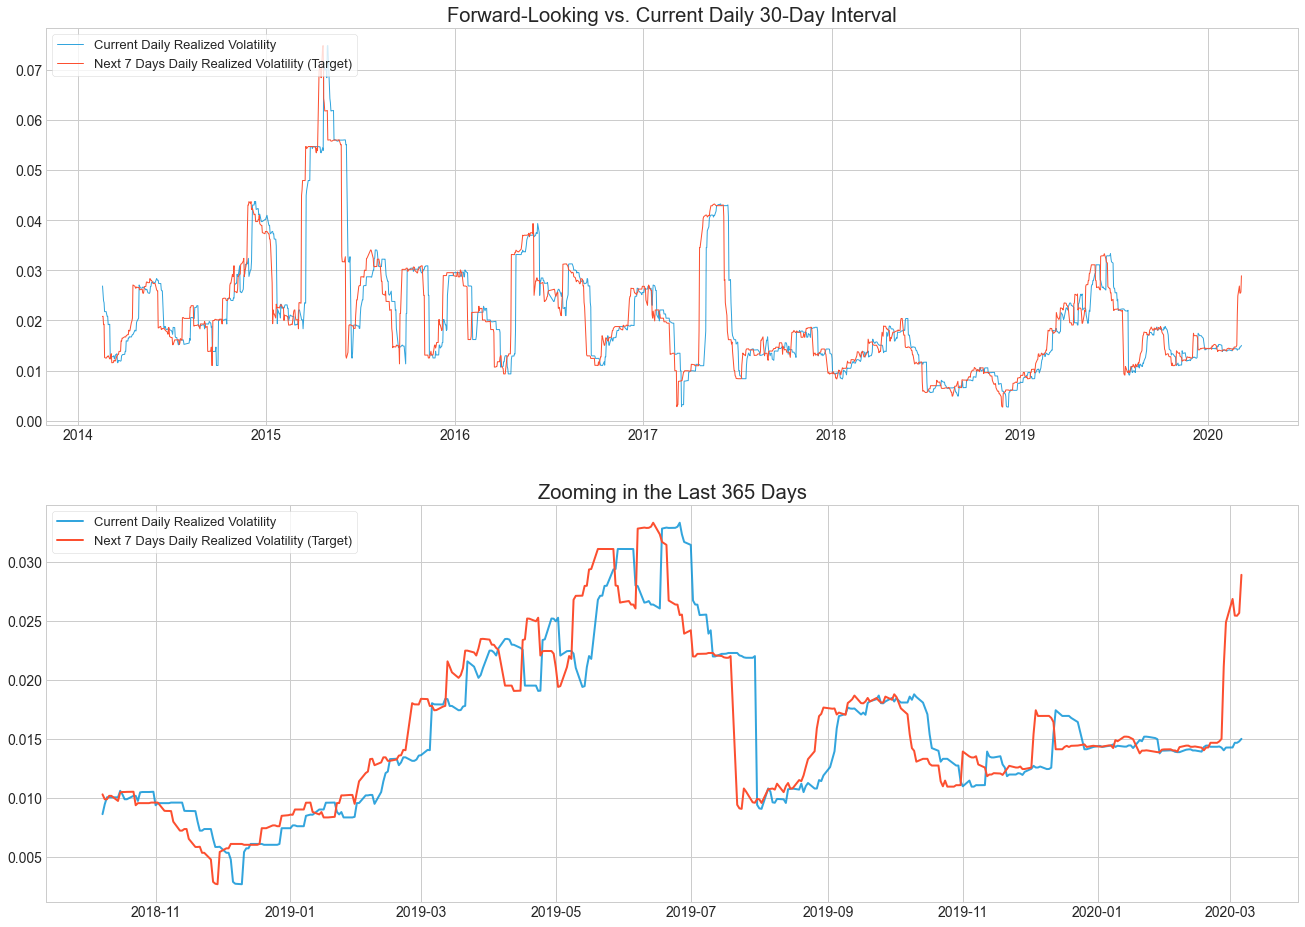

In [33]:
plt.style.use(['seaborn-whitegrid'])

# VISUALIZE REALIZED CURRENT VS. FUTURE VOLATILITY
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(20,15))

ax1.plot(df.vol_current, alpha=.8, lw=1,
         label='Current Daily Realized Volatility')
ax1.plot(df.vol_future, lw=1,
         label=f'Next {n_future} Days Daily Realized Volatility (Target)')

ax2.plot(df.vol_current[-365:], alpha=.8, lw=2,
         label='Current Daily Realized Volatility')
ax2.plot(df.vol_future[-365:], lw=2,
         label=f'Next {n_future} Days Daily Realized Volatility (Target)')

ax1.title.set_text(f'Forward-Looking vs. Current Daily {INTERVAL_WINDOW}-Day Interval')
ax2.title.set_text('Zooming in the Last 365 Days')

ax1.legend(loc='upper left', prop={'size': 13}, frameon=True)
ax2.legend(loc='upper left', prop={'size': 13}, frameon=True)
plt.savefig(os.path.join('daily_vol.jpg'), dpi=300, bbox_inches='tight')
plt.show();


In [34]:
## Lumayan mirip lah ya model sm actual graphnya

### Daily Volatility Grouped by Month

In [35]:
# RESETTING MATPLOTLIB STYLE TO DEFAULT
plt.rcParams.update(plt.rcParamsDefault)

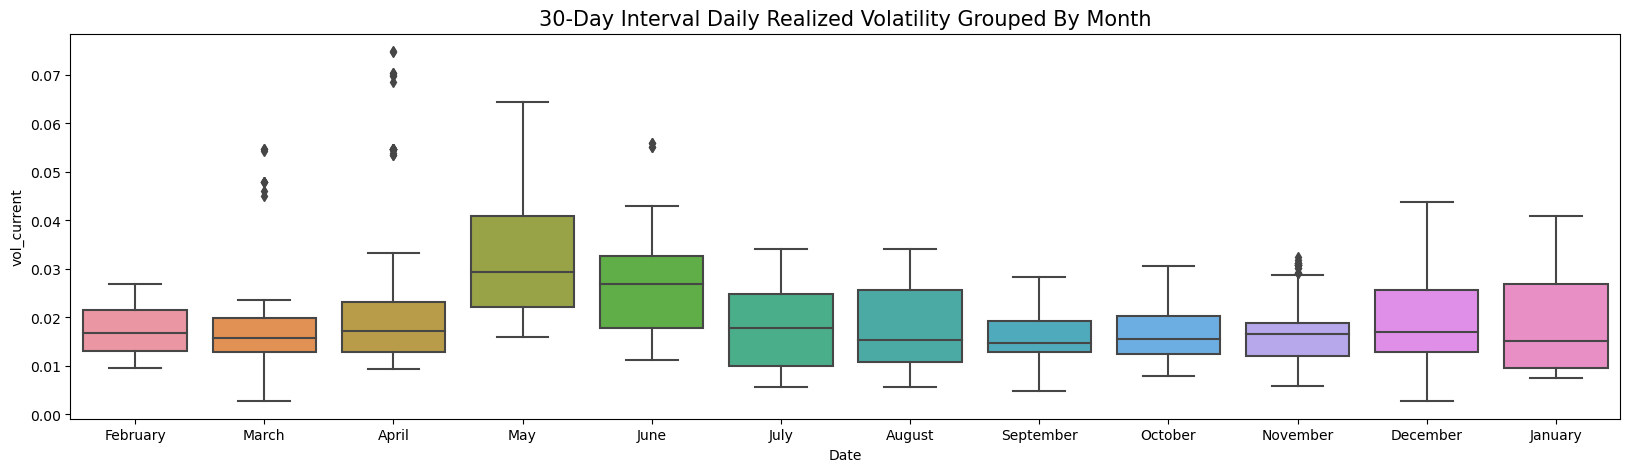

In [36]:
fig, ax = plt.subplots(figsize=(20,5))
sns.boxplot(x=df.index.month_name(), y=df.vol_current, ax=ax)
ax.set_title(f'{INTERVAL_WINDOW}-Day Interval Daily Realized Volatility Grouped By Month', 
             fontsize=15)
plt.savefig(os.path.join('vol_by_month.jpg'), dpi=300, bbox_inches='tight')
plt.show();

SENTIMEN vaksin Covid-19 yang sedang diuji klinis oleh Biofarma bekerjasama dengan perusahaan Tiongkok Sinovax, ikut mendorong kenaikan saham PT Darya-Varia Laboratoria Tbk. (DVLA)

OVER REAKSI: Ia menegaskan, pasar selalu over reaksinya sehingga dalam bursa selalu ada circuit breaker. Tetapi pelan-pelan pasar akan melakukan koreksi jika secara teknikal harga saham sudah dianggap terlalu tinggi.

GORENGAN: Ia meriset, saham-saham yang terbang dalam pekan ini sebagian besar adalah portfolio Asabri dan Jiwasraya. Jadi cara merestorasi kerugian mereka, harga sahamnya dinaikkin. "Kebetulan ada momentum vaksin, sehingga bisa dikatakan tidak menggoreng tetapi karena sentimen," jelasnya.

In [37]:
### April, July, Sept, Oct, Nov, Dec, Jan ada outliers

In [38]:
df.vol_current.sort_values(ascending=False)[:50]

Date
2015-04-30    0.074889
2015-04-29    0.074770
2015-04-23    0.070314
2015-04-24    0.070314
2015-04-27    0.070039
2015-04-22    0.069767
2015-04-28    0.068476
2015-05-04    0.064328
2015-05-05    0.063461
2015-05-11    0.061937
2015-05-08    0.061883
2015-05-06    0.061848
2015-05-07    0.061848
2015-05-15    0.056072
2015-05-13    0.056063
2015-06-03    0.056054
2015-06-01    0.056054
2015-05-12    0.056024
2015-05-29    0.056016
2015-05-28    0.056016
2015-05-27    0.056016
2015-05-26    0.056016
2015-05-25    0.056014
2015-05-21    0.056014
2015-05-22    0.056014
2015-05-18    0.055817
2015-05-20    0.055817
2015-05-19    0.055817
2015-06-05    0.055124
2015-06-04    0.055085
2015-04-07    0.054742
2015-04-08    0.054742
2015-04-01    0.054740
2015-04-02    0.054740
2015-04-06    0.054740
2015-03-27    0.054733
2015-03-30    0.054733
2015-04-09    0.054728
2015-04-13    0.054714
2015-04-10    0.054714
2015-04-14    0.054659
2015-04-15    0.054645
2015-04-20    0.054476
2015-0

It can be observed that:

1)volatility has consistently ranged around number 0.05 but somehow reached some of its higher points in the months of October/November historically



### Daily Volatility Grouped by Year

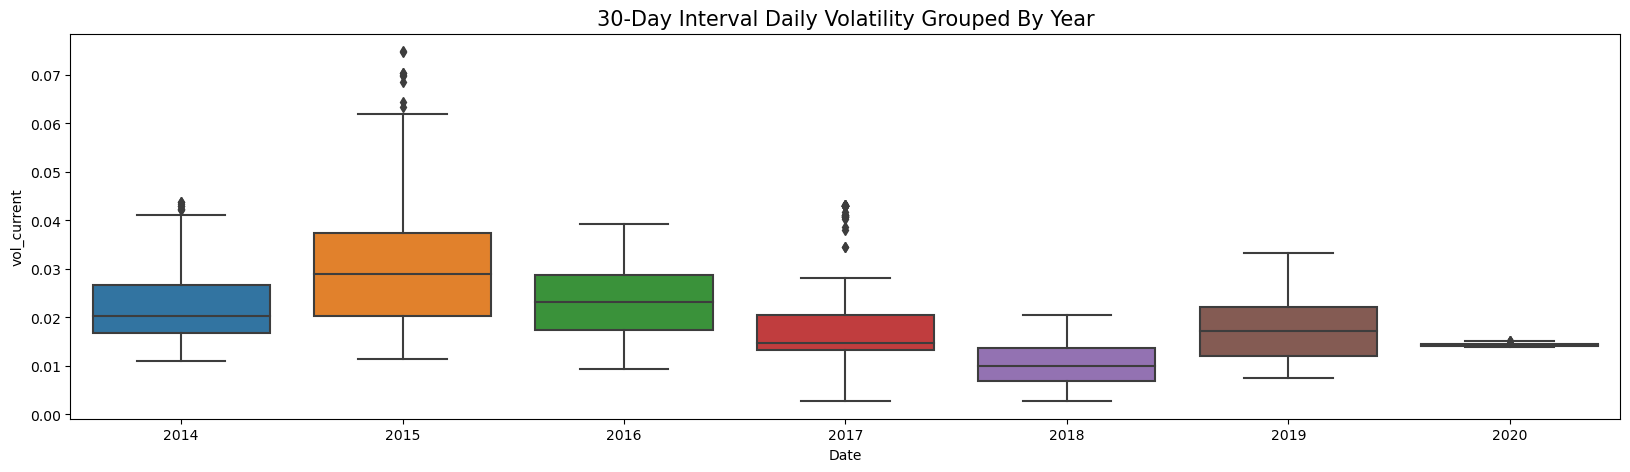

In [39]:
fig, ax = plt.subplots(figsize=(20,5))
sns.boxplot(x=df.index.year, y=df.vol_current, ax=ax)
ax.set_title(f'{INTERVAL_WINDOW}-Day Interval Daily Volatility Grouped By Year', 
             fontsize=15)
plt.savefig(os.path.join('vol_by_year.jpg'), dpi=300, bbox_inches='tight')
plt.show();

2018 kepemilikan saham dvla di etana biotechnology terdilusi

### Daily Volatility Distribution

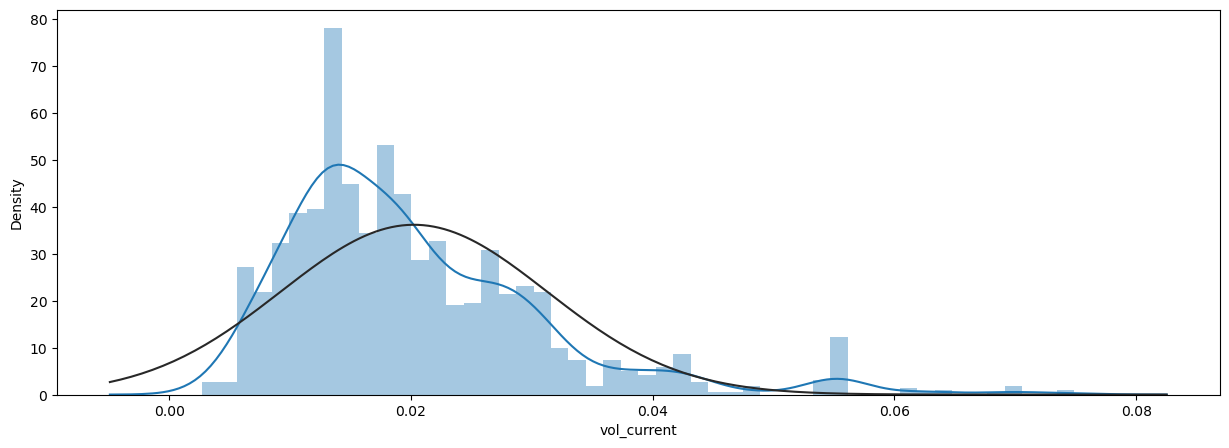

In [40]:
fig, ax = plt.subplots(figsize=(15,5))
sns.distplot(df.vol_current, norm_hist=True, fit=stats.norm,
             bins=50, ax=ax)
plt.show();

The distribution of daily realized volatility is lightly right skewed, with a small number of larger values spreaded thinly on the right.

A skewed right distribution would have smaller median compared to mean, and mode smaller than median (mode < median < mean).

### Returns/Log Returns Stationarity Checking

In [41]:
from statsmodels.tsa.stattools import adfuller

In [42]:
# LOG RETURNS
adfuller_results = adfuller(df.log_returns.dropna())

print(f'ADF Statistic: {adfuller_results[0]}')
print(f'p-value: {adfuller_results[1]}')
print('Critical Values:')
for key, value in adfuller_results[4].items():
    print(f'{key}: {value:.4f}')

ADF Statistic: -8.13946277813445
p-value: 1.0375651837293168e-12
Critical Values:
1%: -3.4347
5%: -2.8635
10%: -2.5678


In [43]:
# RETURNS
adfuller_results = adfuller(df.returns.dropna())

print(f'ADF Statistic: {adfuller_results[0]}')
print(f'p-value: {adfuller_results[1]}')
print('Critical Values:')
for key, value in adfuller_results[4].items():
    print(f'{key}: {value:.4f}')

ADF Statistic: -7.985012644900161
p-value: 2.562825179481514e-12
Critical Values:
1%: -3.4347
5%: -2.8635
10%: -2.5678


Using a significant level alpha of 0.05, p-value for both Returns and Log Returns are significantly smaller than alpha, which means there's enough evidence to reject the Null Hypothesis.

--> Returns and Log returns are both not dependent on time/trend

### Train-Validation-Test Splits

I would split the dataset into 3 parts as follows:

the most recent 30 usable datapoints would be used for final testing - approx. 1.2%
1 full year (365 days) for validation and model tuning during training - approx. 14.7%
and the remaining for training - approx. 84.1%

In [44]:
# PRE-DETERMINE DESIRED TEST & VALIDATION SIZES
test_size = 30
val_size = 365

# CONVERT TO INDICES
split_time_1 = len(df) - (val_size + test_size)
split_time_2 = len(df) - test_size

# GET CORRESPONDING DATETIME INDICES FOR EACH SET
train_idx = df.index[:split_time_1]
val_idx = df.index[split_time_1:split_time_2]
test_idx = df.index[split_time_2:]

In [45]:
print(f'Training \tFrom: {train_idx[0]} \tto: {train_idx[-1]} \t{len(train_idx)} days')
print(f'Validation \tFrom: {val_idx[0]} \tto: {val_idx[-1]} \t{len(val_idx)} days')
print(f'Test \t\tFrom: {test_idx[0]} \tto: {test_idx[-1]} \t{len(test_idx)} days')

Training 	From: 2014-02-17 00:00:00 	to: 2018-08-24 00:00:00 	1129 days
Validation 	From: 2018-08-27 00:00:00 	to: 2020-01-24 00:00:00 	365 days
Test 		From: 2020-01-27 00:00:00 	to: 2020-03-06 00:00:00 	30 days


The target here would be vol_future which represents the daily realized volatility of the next n_future days from today (average daily volatility from t + n_future - INTERVAL_WINDOW + 1 to time step t + n_future).

For example, using an n_future value of 7 and an INTERVAL_WINDOW of 30, the value that I want to predict at time step t would be the average daily realized volatility from time step t-22 to time step t+7

In [46]:
# SPLIT FORWARD VOLATILITY INTO 3 PARTS 
# (this would be the target)
y_train = df.vol_future[train_idx]
y_val = df.vol_future[val_idx]
y_test = df.vol_future[test_idx]

In [47]:
# SPLIT CURRENT DAILY REALIZED VOLATILITY INTO 3 PARTS 
# (this would be the input for baseline, random walk, and NN models)
x_train = df.vol_current[train_idx]
x_val = df.vol_current[val_idx]
x_test = df.vol_current[test_idx]

In [48]:
# SPLIT RETURNS INTO 3 PARTS
# (this would be the input for GARCH models)
r_train = df.returns[train_idx]
r_val = df.returns[val_idx]
r_test = df.returns[test_idx]

In [49]:
# SPLIT LOG RETURNS INTO 3 PARTS
# (mostly for visualization)
lr_train = df.log_returns[train_idx]
lr_val = df.log_returns[val_idx]
lr_test = df.log_returns[test_idx]

### Feature Normalization
As I am going to build various types of models based on different algorithms with slightly different assumptions using different types of parameters, it's probably better to normalize the volatilities using MinMaxScaler to standardize performance comparison among different models.

In [50]:
# INITIATE SCALER
scaler_vol = MinMaxScaler()

# FIT SCALER TO CURRENT REALIZED VOLATILITY IN TRAINING
scaler_vol = scaler_vol.fit(x_train.values.reshape(-1,1))

In [51]:
# TRANSFORM TRAINING VOLATILITIES 
x_train_scaled = pd.Series(scaler_vol.transform(x_train.values.reshape(-1,1))[:,0],
                           index=train_idx)
y_train_scaled = pd.Series(scaler_vol.transform(y_train.values.reshape(-1,1))[:,0],
                           index=train_idx)

# TRANSFORMING VALIDATION VOLATILITIES
x_val_scaled = pd.Series(scaler_vol.transform(x_val.values.reshape(-1,1))[:,0],
                           index=val_idx)
y_val_scaled = pd.Series(scaler_vol.transform(y_val.values.reshape(-1,1))[:,0],
                           index=val_idx)

# TRANSFORMING TEST VOLATILITIES
x_test_scaled = pd.Series(scaler_vol.transform(x_test.values.reshape(-1,1))[:,0],
                           index=test_idx)
y_test_scaled = pd.Series(scaler_vol.transform(y_test.values.reshape(-1,1))[:,0],
                           index=test_idx)

### Train-Validation-Test Visualization

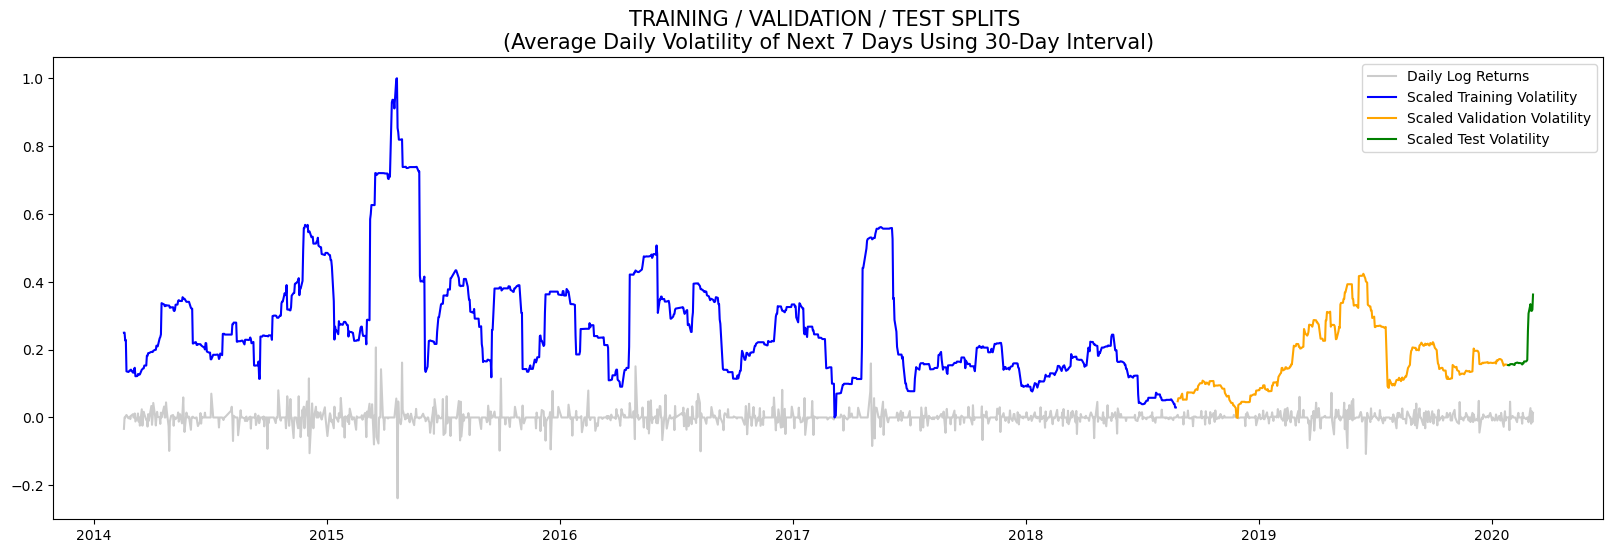

In [52]:
plt.figure(figsize=(20,6))

plt.plot(df.log_returns, color='gray', label='Daily Log Returns', alpha=0.4)

plt.plot(y_train_scaled, color='blue', label='Scaled Training Volatility')
plt.plot(y_val_scaled, color='orange', label='Scaled Validation Volatility')
plt.plot(y_test_scaled, color='green', label='Scaled Test Volatility')

plt.plot()
plt.title(f'TRAINING / VALIDATION / TEST SPLITS \n(Average Daily Volatility of Next {n_future} Days Using {INTERVAL_WINDOW}-Day Interval)', 
          fontsize=15)
plt.legend(frameon=True)
plt.savefig(os.path.join('train_val_test.jpg'), dpi=300, bbox_inches='tight')
plt.show();

### Modeling

### Performance Metrics

Usually with financial time series, if we just shift through the historic data trying different methods, parameters and timescales, it's almost certain to find to some strategy with in-sample profitability at some point. However the whole purpose of "forecasting" is to predict the future based on currently available information, and a model that performs best on training data might not be the best when it comes to out-of-sample generalization (or overfitting). Avoiding/Minimizing overfitting is even more important in the constantly evolving financial markets where the stake is high.

The 2 main metrics I'd be using are RMSPE (Root Mean Squared Percentage Error) and RMSE (Root Mean Square Errors) with RMSPE prioritized. Timescaling is very important in the calculation of volatility due to the level of freedom in frequency/interval window selection. Therefore I think RMSPE would help capture degree of errors compared to desired target values better than other metrics. Also RMSPE would punish large errors more than regular MAPE (Mean Absolute Percentage Error), which is what I want to do here.

RMSE and RMSPE would be tracked across different models' performance on validation set forecasting to indicate their abilities to generalize on out-of-sample data.

In [53]:
# DEFINE ROOT MEAN SQUARED PERCENTAGE ERROR FUNCTION
def RMSPE(y_true, y_pred):
    """
    Compute Root Mean Squared Percentage Error between 2 arrays
    """
    output = np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))
    return output

In [54]:
# DEFINE ROOT MEAN SQUARED ERROR FUNCTION
def RMSE(y_true, y_pred):
    """
    Compute Root Mean Squared Error between 2 arrays
    """
    output = np.sqrt(mse(y_true, y_pred))
    return output

In [55]:
# INITIATE A DATAFRAME FOR MODEL PERFORMANCE TRACKING & COMPARISON 
perf_df = pd.DataFrame(columns=['Model', 'Validation RMSPE', 'Validation RMSE'])

In [56]:
# A FUNCTION THAT LOGS MODEL NAME, RMSE AND RMPSE INTO perf_df
# FOR EASY COMPARISON LATER
def log_perf(y_true, y_pred, model_name):
    perf_df.loc[len(perf_df.index)] = [model_name, 
                                       RMSPE(y_true, y_pred), 
                                       RMSE(y_true, y_pred)]
    return perf_df

In [57]:
# PLOTTING MODEL PREDICTIONS VS. TARGET VALUES
def viz_model(y_true, y_pred, model_name):
    plt.rcParams["axes.grid"] = False
    plt.figure(figsize=(20,7))
    plt.plot(y_true, color='blue', 
             label=f"Scaled Next {n_future} days' Daily Volatility (Target)")
    plt.plot(x_val_scaled, color='gray',  ls='--',
             label=f"Scaled Current Daily Volatility")
    plt.plot(y_pred, color='orange', lw=2.5,
             label=f'Forecasted Volatility')
    
    plt.plot(lr_val, color='gray', alpha=0.4,
             label='Daily Log Returns')

    plt.title(f'{model_name} \non Validation Data', fontsize=15)
    plt.legend(loc='best', frameon=True)

### Model #1 - Baseline Model
One of the essential characteristics of Volatility is it's mean-revert over the long term. Therfore my first baseline model his would be a very simple one that only outputs the average current realized volatility of the whole training set as predictions everything.

In [58]:
# CALCULATE THE MEAN OF SCALED TRAINING DATA
mean_train_vol = x_train_scaled.mean()
mean_train_vol

0.2683391761169487

In [59]:
# CREATE SERIES OF PREDICTIONS FOR BASELINE MODEL ON VALIDATION SET
baseline_preds = np.ones(len(val_idx)) * mean_train_vol
baseline_preds = pd.Series(baseline_preds, index=lr_val.index)

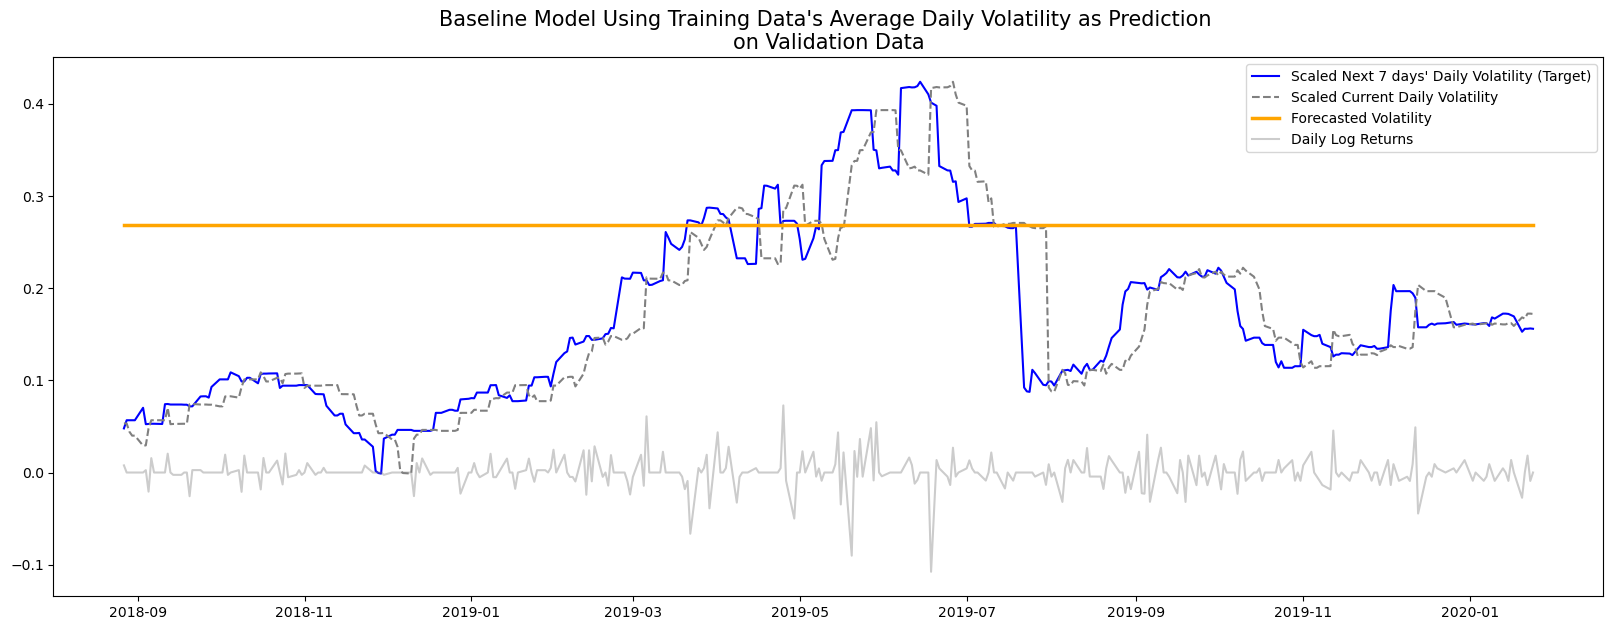

In [60]:
viz_model(y_val_scaled, baseline_preds, 
          f"Baseline Model Using Training Data's Average Daily Volatility as Prediction")
plt.savefig(os.path.join('baseline.jpg'), dpi=300, bbox_inches='tight')
plt.show();

In [61]:
log_perf(y_val_scaled, baseline_preds, 'Mean Baseline')

Model  Validation RMSPE  Validation RMSE
0  Mean Baseline         28.954222         0.137538

### Model #2 - Random Walk Naive Forecasting
A commonly known fact about volatility is that it tends to be autocorrelated, and clusters in the short-term. This property can be used to implement a naive model that just "predicts" future volatility by using whatever the daily volatility was at the immediate previous time step.

In this case, I'll use the average daily volatility of the most recent INTERVAL_WINDOW as predictions for the next 7 days, which is essentially using vol_current at time step t and prediction for vol_future at time step t.

In [62]:
# USING THE PREVIOUS n_future DAY'S VOLATILITY
random_walk_preds = x_val_scaled

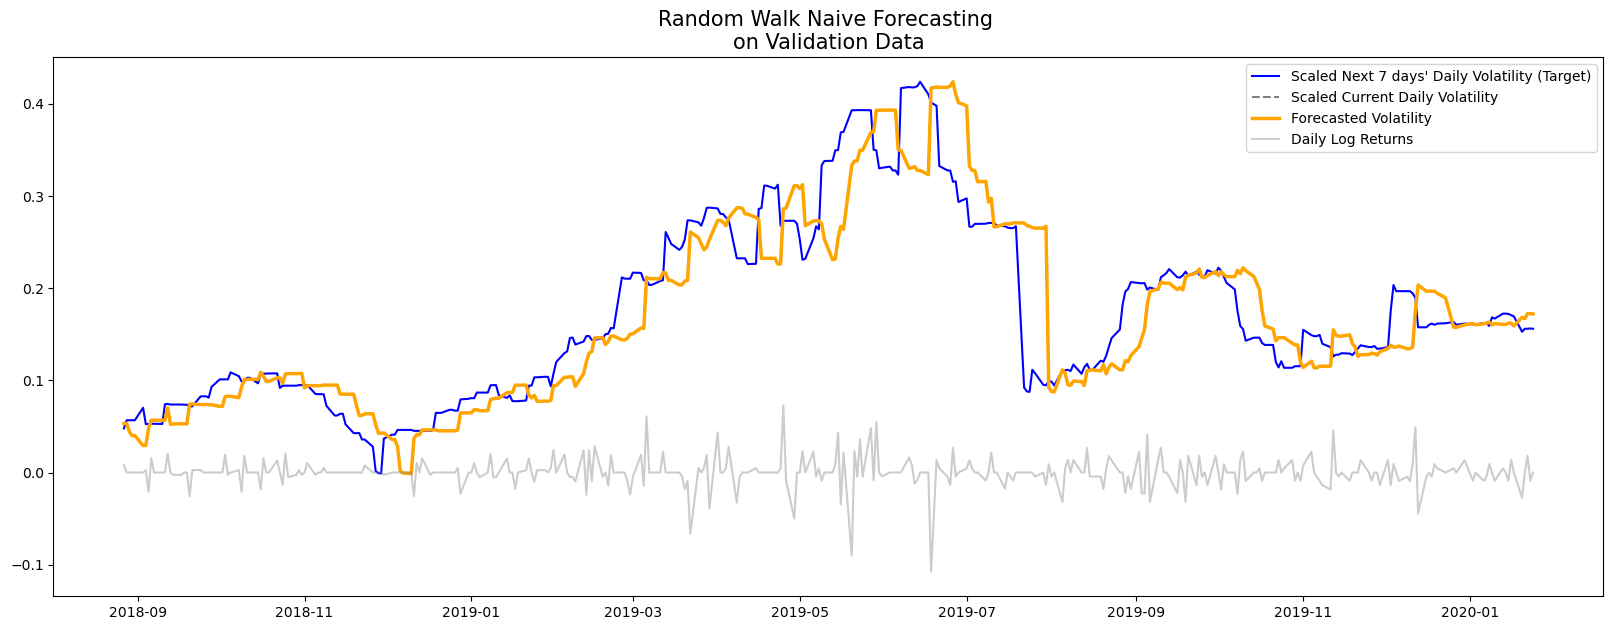

In [63]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, random_walk_preds, 'Random Walk Naive Forecasting')
plt.savefig(os.path.join('naive.jpg'), dpi=300, bbox_inches='tight')
plt.show();

In [64]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, random_walk_preds, 
         'Random Walk Naive Forecasting')

Model  Validation RMSPE  Validation RMSE
0                  Mean Baseline         28.954222         0.137538
1  Random Walk Naive Forecasting          4.742650         0.044705

### Model #3 - GARCH
(Reference: http://users.metu.edu.tr/ozancan/ARCHGARCHTutorial.html)

GARCH stands for Generalized Autoregressive Conditional Heteroskedasticity, which is an extension of the ARCH model (Autoregressive Conditional Heteroskedasticity).

GARCH includes lag variance terms with lag residual errors from a mean process, and is the traditional econometric approach to volatility prediction of financial time series.

Mathematically, GARCH can be represented as follows:

 
 
 
in which 
 is variance at time step t and 
 is the model residuals at time step t-1

GARCH(1,1) only contains first-order lagged terms and the mathematic equation for it is:

 
where ,  and  sum up to 1, and  is the long term variance.

(Reference: Sinclair)

GARCH is generally regarded as an insightful improvement on naively assuming future volatility will be like the past, but also considered widely overrated as predictor by some experts in the field of volatility. GARCH models capture the essential characteristics of volatility: volatility tomorrow will be close to what it is today (clustering), and volatility in the long term will probably mean revert (meaning it'd be close to whatever the historical long-term average has been).

### Basic GARCH

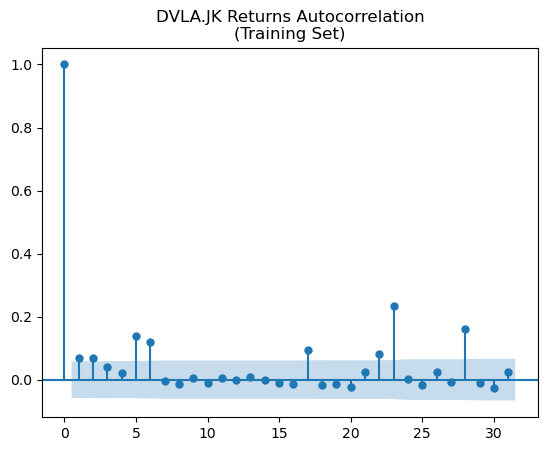

In [65]:
# VISUALIZE AUTOCORRELATION OF SQUARED RETURNS
plot_acf(r_train**2, 
          title=f'{tckr.upper()} Returns Autocorrelation\n(Training Set)');

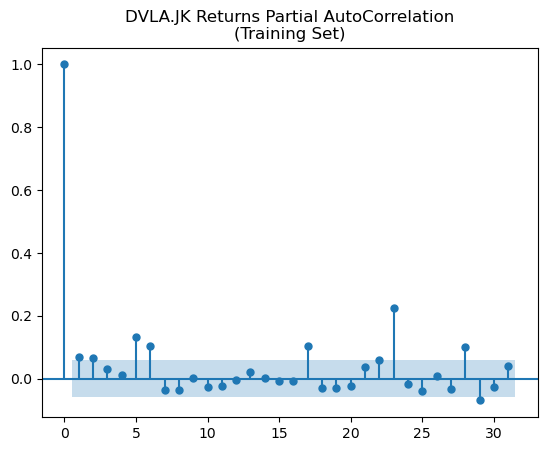

In [66]:
# VISUALIZE PARTIAL AUTOCORRELATION OF SQUARED RETURNS
plot_pacf(r_train**2, 
          title=f'{tckr.upper()} Returns Partial AutoCorrelation\n(Training Set)');

In [67]:
from arch import arch_model

In [68]:
gm_1 = arch_model(r_train, p=1, q=1)
result_1 = gm_1.fit(disp='off')
print()
print(result_1.summary())


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2474.84
Distribution:                  Normal   AIC:                           4957.67
Method:            Maximum Likelihood   BIC:                           4977.79
                                        No. Observations:                 1129
Date:                Wed, Jul 06 2022   Df Residuals:                     1128
Time:                        12:44:22   Df Model:                            1
                                Mean Model                               
                  coef    std err          t      P>|t|  95.0% Conf. Int.
-------------------------------------------------------------------------
mu         -7.7049e-03  6.356e-02     -0.121      0.904 [ -0.132, 

In [69]:
# INITIATE SCALER
scaler_garch_vol = MinMaxScaler()

# GET ESTIMATED CONDITIONAL VOLATILITY FROM FITTED MODEL
cond_vol_arr = result_1.conditional_volatility.values.reshape(-1,1)

# FITTING SCALER TO MODEL'S ESTIMATED CONDITIONAL VOLATILITY
scaler_garch_vol = scaler_garch_vol.fit(cond_vol_arr)
scaled_cond_vol = pd.Series(scaler_garch_vol.transform(cond_vol_arr)[:,0],
                            index=train_idx)

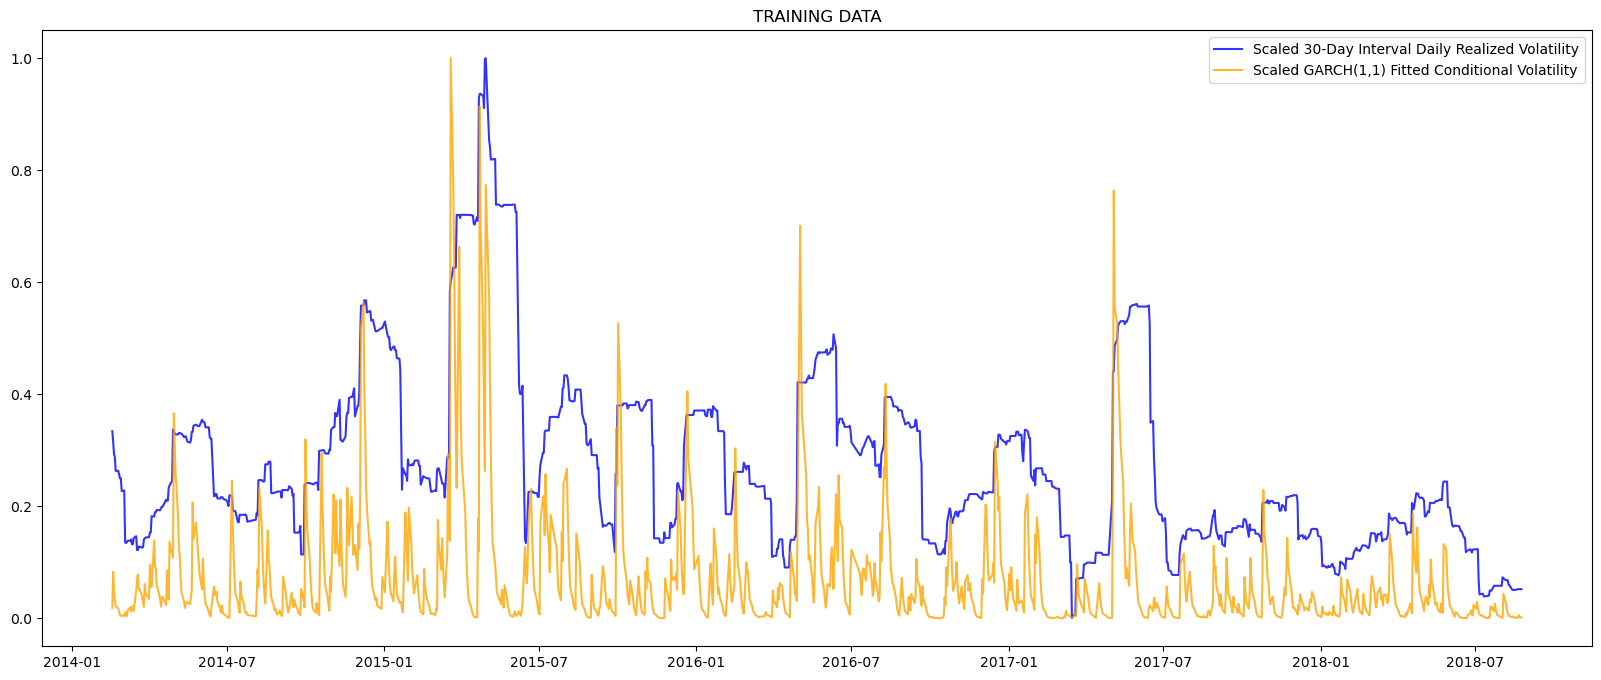

In [70]:
# VISUALIZE MODEL'S ESTIMATED CONDITIONAL VOLATILITY 
# WITH SCALED vol_current CALCULATED ABOVE
fig, ax = plt.subplots(figsize=(20,8))

ax.plot(x_train_scaled, color='blue', alpha=0.8,
        label=f'Scaled {INTERVAL_WINDOW}-Day Interval Daily Realized Volatility')
ax.plot(scaled_cond_vol, color='orange', alpha=0.8,
        label='Scaled GARCH(1,1) Fitted Conditional Volatility')
ax.set_title('TRAINING DATA')
plt.legend()
plt.show();

### Analytical-based Forecasting
(Source: https://arch.readthedocs.io/en/latest/univariate/univariate_volatility_forecasting.html)

I am implementing rolling one-step forecasting here by refitting the model to ALL the datapoints available up to a certain time step before generating prediction for the next n_future days. For example, to make prediction on vol_future at time step t, I would fit the model to all the returns available up to time step t and then obtain the average forecasted volatility for a horizon of n_future = 7.

The volatility forecasts from the GARCH models using percent returns as input are on a totally different scale compared to the volatilities calculated from log returns. Therefore I am going to normalize the forecasted volatility based on the model's conditional_volatility output from the training data, and only comparing the scaled versions of volatilities on the Validation set.

In [71]:
# ROLLING FORECAST
# INITIALIZING rolling_forecast
rolling_forecasts = []
idx = df.index

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(val_idx)):
    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = val_idx[i]
    train = df.returns[:idx]
    
    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, vol='GARCH', p=1, q=1,
                       dist='normal')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION n_future DAYS OUT
    vaR = model_fit.forecast(horizon=n_future, 
                             reindex=False).variance.values
    pred = np.sqrt(np.mean(vaR))

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

gm_1_preds = pd.Series(rolling_forecasts, index=val_idx)

In [72]:
# TRANSFORM PREDICTIONS USING FITTED SCALER
gm_1_preds_scaled = pd.Series(scaler_garch_vol.transform(np.array(rolling_forecasts).reshape(-1,1))[:,0], 
                              index=val_idx)

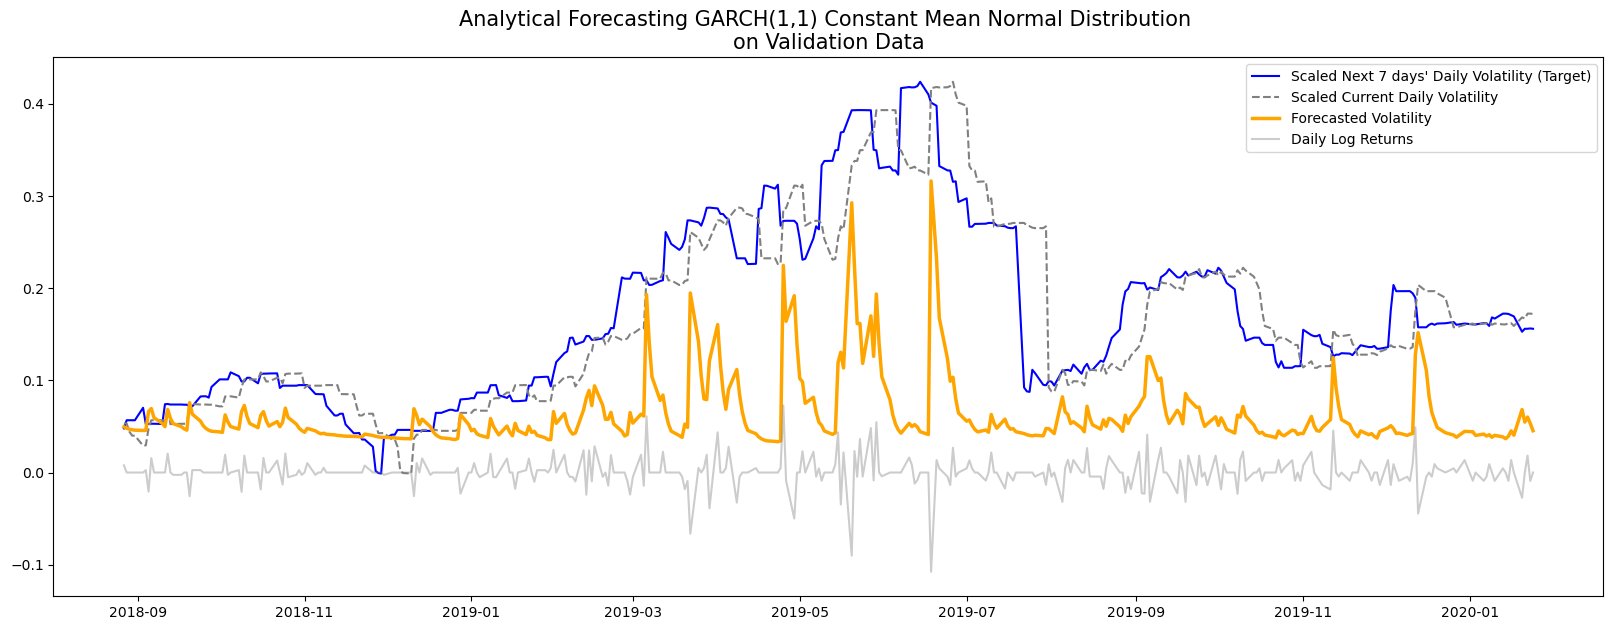

In [73]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, gm_1_preds_scaled, 
          'Analytical Forecasting GARCH(1,1) Constant Mean Normal Distribution')

In [74]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, gm_1_preds_scaled, 
         'GARCH(1,1) | Constant Mean | Normal Dist')

Model  Validation RMSPE  Validation RMSE
0                             Mean Baseline         28.954222         0.137538
1             Random Walk Naive Forecasting          4.742650         0.044705
2  GARCH(1,1) | Constant Mean | Normal Dist          4.243133         0.135375

DI RMSE bahkan garch lebih gede drpd mean baseline. auto drop

### Model #4 - Neural Networks
While GARCH remains the gold standard for volatility prediction within traditional financial institutions, there has been an increasing numbers of professionals and researchers turning to Machine Learning, especially Neural Networks, to gain insights into the financial markets in recent years.

(Reference: Sinclair (2020))

Traders' theory of the market being inherently efficient (Efficient Market Hypothesis or EHM) states that share prices reflects all information and consistently outperforming the overall market is impossible. The more efficient a market is, the more random and unpredictable the returns will be, and thus a perfectly efficient market will be completely unpredictable.

There are other arguments against EMH, and ones of the most prominent one is based on Behavioral Finance: compared to the human history of 200,000 years, the market has not been around for that long. For example, equity options have only been traded in liquid, transparent market since the CBOE opened in 1973; and the average lifetime of an S&P500 company is approx. 20 years. It means that some psychological tendencies of human beings have 200,000 years of evidence behind them, and that a lot of the movements of the markets that were driven by participants' behaviors will likely repeat itself at a later point. Therefore the market system cannot be totally random, it must have some patterns. Those patterns are extremely difficult to exploit due to the multitude of factors that interact and drive the market.

And what could be better than Neural Networks for that?

In [75]:
import tensorflow as tf

In [76]:
# CONVERT AN SERIES TO MATRIX DATASET
def windowed_dataset(x_series, y_series, lookback_window):
    dataX, dataY = [], []
    for i in range((lookback_window-1), len(x_series)):
        from_idx = x_series.index[i-lookback_window+1]
        to_idx = x_series.index[i]
        a = x_series[from_idx:to_idx].values
        dataX.append(a)
        dataY.append(y_series[to_idx])

    return np.array(dataX), np.array(dataY)

In [77]:
from keras import backend as K

In [78]:
def rmspe(y_true, y_pred):
    '''
    Compute Root Mean Square Percentage Error between two arrays
    that can be used as metrics for NN during training
    '''
    loss = K.sqrt(K.mean(K.square((y_true - y_pred) / y_true)))

    return loss

In [79]:
def val_forecast(model):
    forecast = []
    idx = df.index

    # ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
    for i in range(len(val_idx)):
        # GET THE DATA AT THE PREVIOUS n_past TIME STEPS
        # (including current value)
        from_idx = idx[split_time_1 + i - n_past + 1]
        to_idx = idx[split_time_1 + i]
        pred = model.predict(df.vol_current[from_idx:to_idx].values[np.newaxis])
        forecast.append(pred)

    forecast = np.array(forecast)[:, 0, 0]
    preds = pd.Series(forecast, index=val_idx)

    preds_scaled = pd.Series(scaler_vol.transform(preds.values.reshape(-1,1))[:,0],
                                index=val_idx)
    return preds_scaled

In [80]:
def viz_train_val_metrics(model_hist):
    fig, ax = plt.subplots(figsize=(20,8))

    # PLOT MSE - LEFT Y-AXIS
    # TRAINING
    ln11 = ax.plot(range(len(model_hist.history['loss'])), 
                model_hist.history['loss'], color='lightblue',
                label='Training MSE')
    # VALIDATION
    ln12 = ax.plot(range(len(model_hist.history['loss'])), 
                model_hist.history['val_loss'], color='darkblue',
                label='Validation MSE')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('MSE')

    # PLOT RMSE - RIGHT Y-AXIS
    ax2 = ax.twinx()
    ln21 = ax2.plot(range(len(model_hist.history['loss'])), 
                model_hist.history['rmspe'], color='pink',
                label='Training RMSPE')
    ln22 = ax2.plot(range(len(model_hist.history['loss'])), 
                model_hist.history['val_rmspe'], color='red',
                label='Validation RMSPE')
    ax2.set_ylabel('RMSPE')

    # COMBINING LALBELS FOR 4 LINES INTO 1 LEGEND
    lns = ln11 + ln12 + ln21 + ln22
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc='best')

    ax.set_title('Training vs. Validation Loss Metrics', fontsize=15)
    plt.show();

In [81]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
from decimal import Decimal

In [82]:
# CLEARING ANY INTERNAL VARIABLES TO PREVENT MODELS
# FROM IMPACTING LATER VERSIONS OF THEMSELVES
tf.keras.backend.clear_session()

n_past = 14
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)
mat_X_val, mat_y_val = windowed_dataset(x_val, y_val, n_past)

lstm_1 = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), 
                           input_shape=[None]),                            
    # ADDING 1 LSTM LAYER
    tf.keras.layers.LSTM(20),
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_1.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_1.h5',
                                save_best_only=True,
                                monitor='loss')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=20,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

lstm_1_res = lstm_1.fit(mat_X_train, mat_y_train, epochs=200,
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_data=(mat_X_val, mat_y_val),
                        verbose=1, batch_size=batch_size, shuffle=True)

Epoch 1/200
18/18 [==============================] - 3s 50ms/step - loss: 2.4939e-04 - rmspe: 0.9925 - val_loss: 4.5635e-05 - val_rmspe: 0.5335
Epoch 2/200
18/18 [==============================] - 0s 15ms/step - loss: 1.3995e-04 - rmspe: 0.7365 - val_loss: 8.7477e-05 - val_rmspe: 0.9377
Epoch 3/200
18/18 [==============================] - 0s 10ms/step - loss: 1.0496e-04 - rmspe: 0.6412 - val_loss: 6.5631e-05 - val_rmspe: 0.8192
Epoch 4/200
18/18 [==============================] - 0s 11ms/step - loss: 8.3713e-05 - rmspe: 0.5972 - val_loss: 4.5819e-05 - val_rmspe: 0.6896
Epoch 5/200
18/18 [==============================] - 0s 10ms/step - loss: 7.0372e-05 - rmspe: 0.5395 - val_loss: 1.8194e-05 - val_rmspe: 0.4048
Epoch 6/200
18/18 [==============================] - 0s 11ms/step - loss: 6.4485e-05 - rmspe: 0.4974 - val_loss: 2.4091e-05 - val_rmspe: 0.4890
Epoch 7/200
18/18 [==============================] - 0s 11ms/step - loss: 6.3599e-05 - rmspe: 0.5036 - val_loss: 1.4174e-05 - val_rmspe:

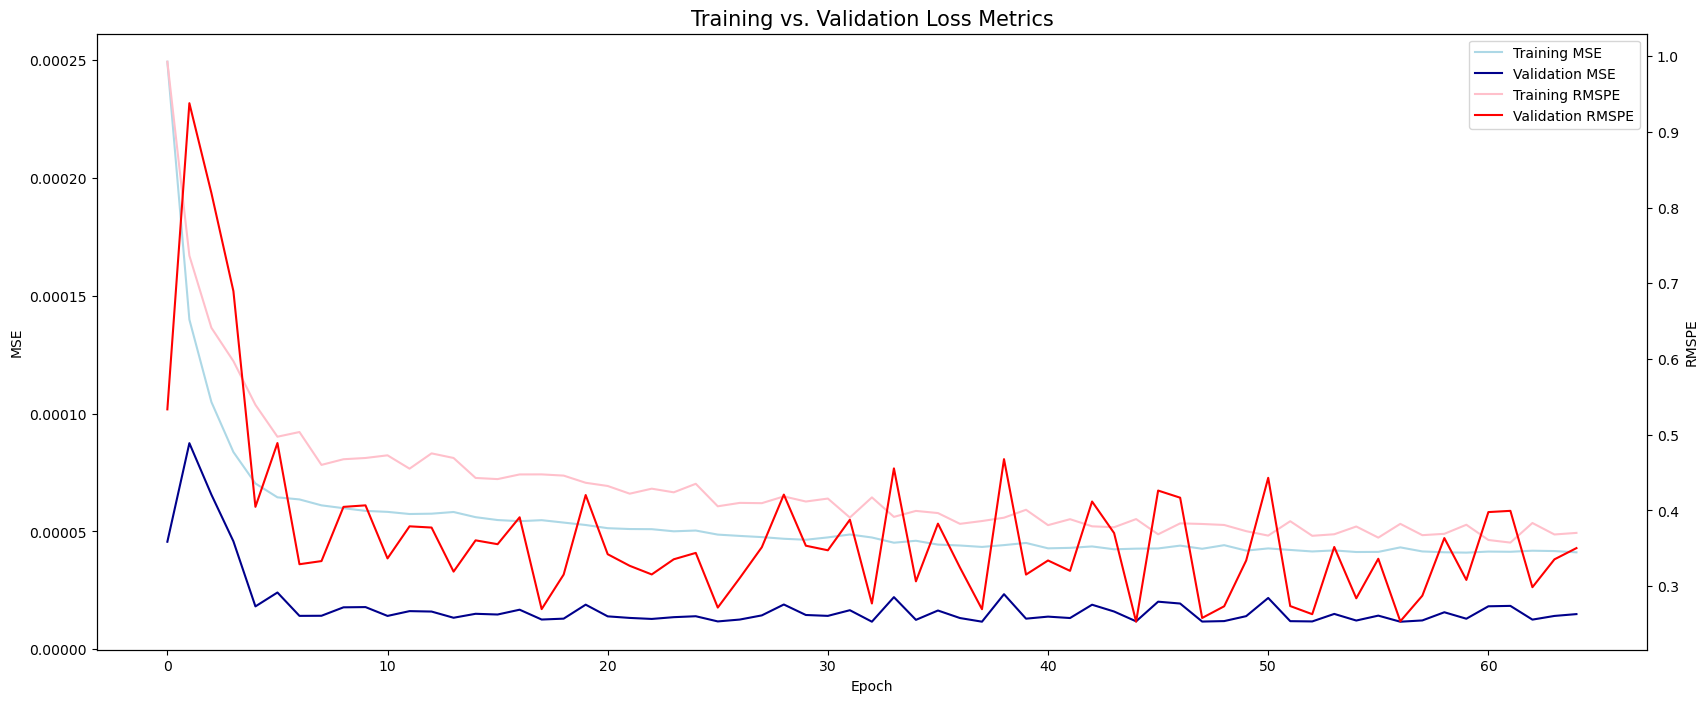

In [83]:
# VISUALIZE TRAINING VS. VALIDATION LOSS METRICS
viz_train_val_metrics(lstm_1_res)

In [84]:
# FORECASTING ON VALIDATION SET
lstm_1_preds_scaled = val_forecast(lstm_1)

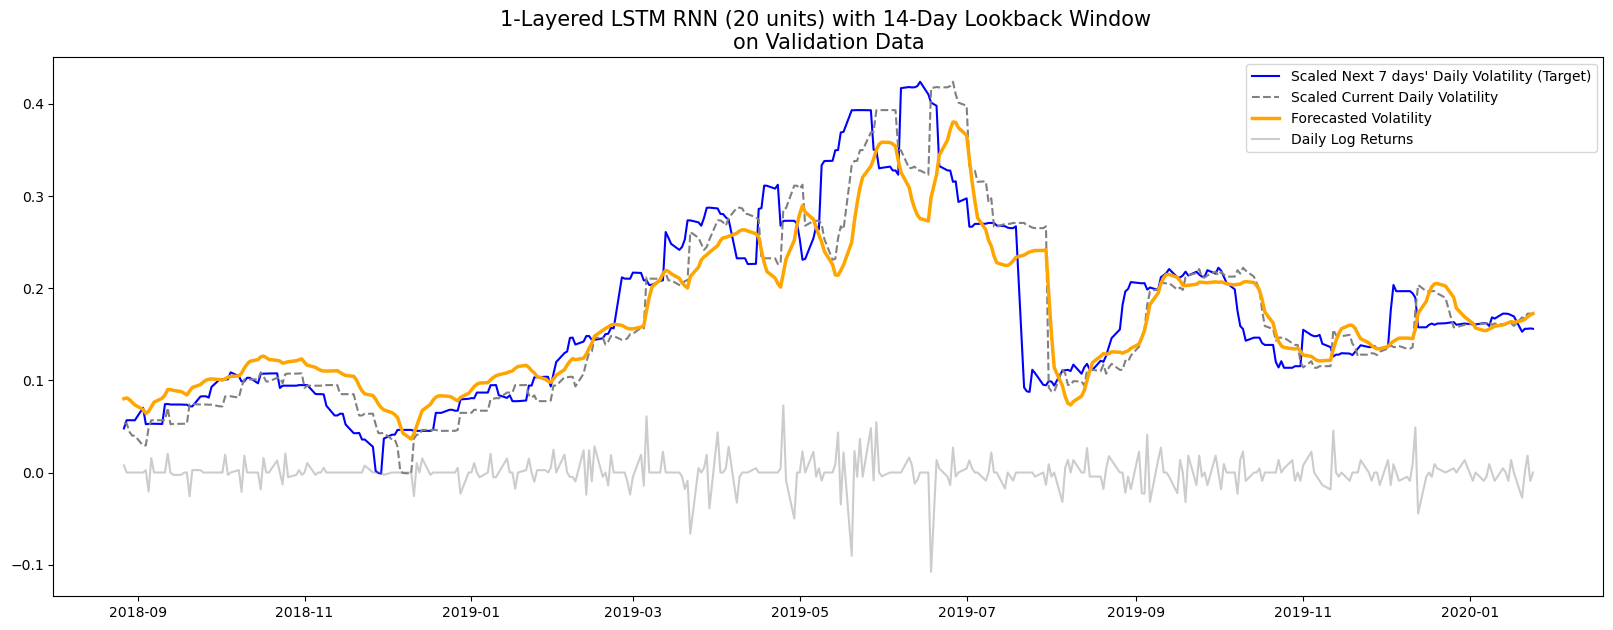

In [85]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, lstm_1_preds_scaled, 
          f"1-Layered LSTM RNN (20 units) with {n_past}-Day Lookback Window")

In [86]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, lstm_1_preds_scaled, 
         f"LSTM 1 layer 20 units | n_past={n_past}")

Model  Validation RMSPE  Validation RMSE
0                             Mean Baseline         28.954222         0.137538
1             Random Walk Naive Forecasting          4.742650         0.044705
2  GARCH(1,1) | Constant Mean | Normal Dist          4.243133         0.135375
3         LSTM 1 layer 20 units | n_past=14          8.020711         0.047053

In [87]:
# CLEARING ANY INTERNAL VARIABLES TO PREVENT MODELS
# FROM IMPACTING LATER VERSIONS OF THEMSELVES
tf.keras.backend.clear_session()

# INCREASING LOOKBACK WINDOW TO 1 MONTH
n_past = 30
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)
mat_X_val, mat_y_val = windowed_dataset(x_val, y_val, n_past)

lstm_2 = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), 
                           input_shape=[None]),                            
    # ADDING 1st BIDIRECTIONAL LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    # ADDING 2nd BIDIRECTIONAL LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_2.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_2.h5',
                                save_best_only=True,
                                monitor='loss')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=20,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

print(lstm_2.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
 bidirectional (Bidirectiona  (None, None, 64)         8704      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               10368     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 19,105
Trainable params: 19,105
Non-trainable params: 0
_________________________________________________________________
None


In [88]:
# FITTING lstm_2 TO TRAINING DATA
lstm_2_res = lstm_2.fit(mat_X_train, mat_y_train, epochs=200,
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_data=(mat_X_val, mat_y_val),
                        verbose=1, batch_size=batch_size, shuffle=True)

Epoch 1/200
18/18 [==============================] - 8s 107ms/step - loss: 2.1831e-04 - rmspe: 0.8325 - val_loss: 1.7173e-04 - val_rmspe: 1.2470
Epoch 2/200
18/18 [==============================] - 0s 24ms/step - loss: 1.1582e-04 - rmspe: 0.7549 - val_loss: 4.1224e-05 - val_rmspe: 0.6288
Epoch 3/200
18/18 [==============================] - 0s 23ms/step - loss: 8.6922e-05 - rmspe: 0.5551 - val_loss: 1.8465e-05 - val_rmspe: 0.3428
Epoch 4/200
18/18 [==============================] - 0s 25ms/step - loss: 7.0659e-05 - rmspe: 0.5006 - val_loss: 2.6469e-05 - val_rmspe: 0.5016
Epoch 5/200
18/18 [==============================] - 0s 23ms/step - loss: 6.0167e-05 - rmspe: 0.4669 - val_loss: 1.6139e-05 - val_rmspe: 0.3747
Epoch 6/200
18/18 [==============================] - 0s 25ms/step - loss: 5.3711e-05 - rmspe: 0.4634 - val_loss: 1.5117e-05 - val_rmspe: 0.3583
Epoch 7/200
18/18 [==============================] - 0s 24ms/step - loss: 5.0698e-05 - rmspe: 0.4189 - val_loss: 1.4280e-05 - val_rmspe

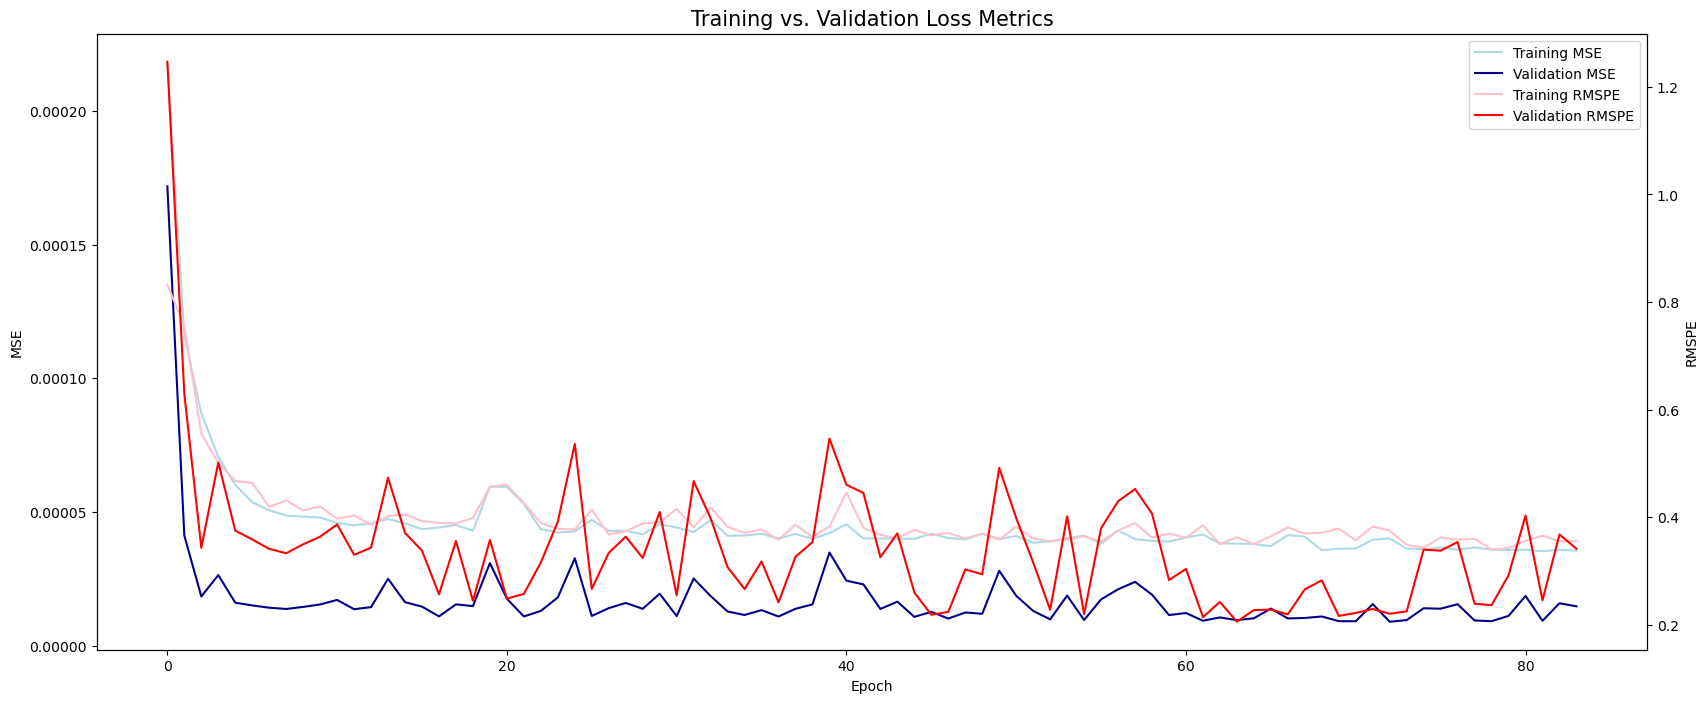

In [89]:
# VISUALIZING PERFORMANCE METRICS
viz_train_val_metrics(lstm_2_res)

In [90]:
# MAKE PREDICTIONS ON VALIDATION SET
lstm_2_preds_scaled = val_forecast(lstm_2)

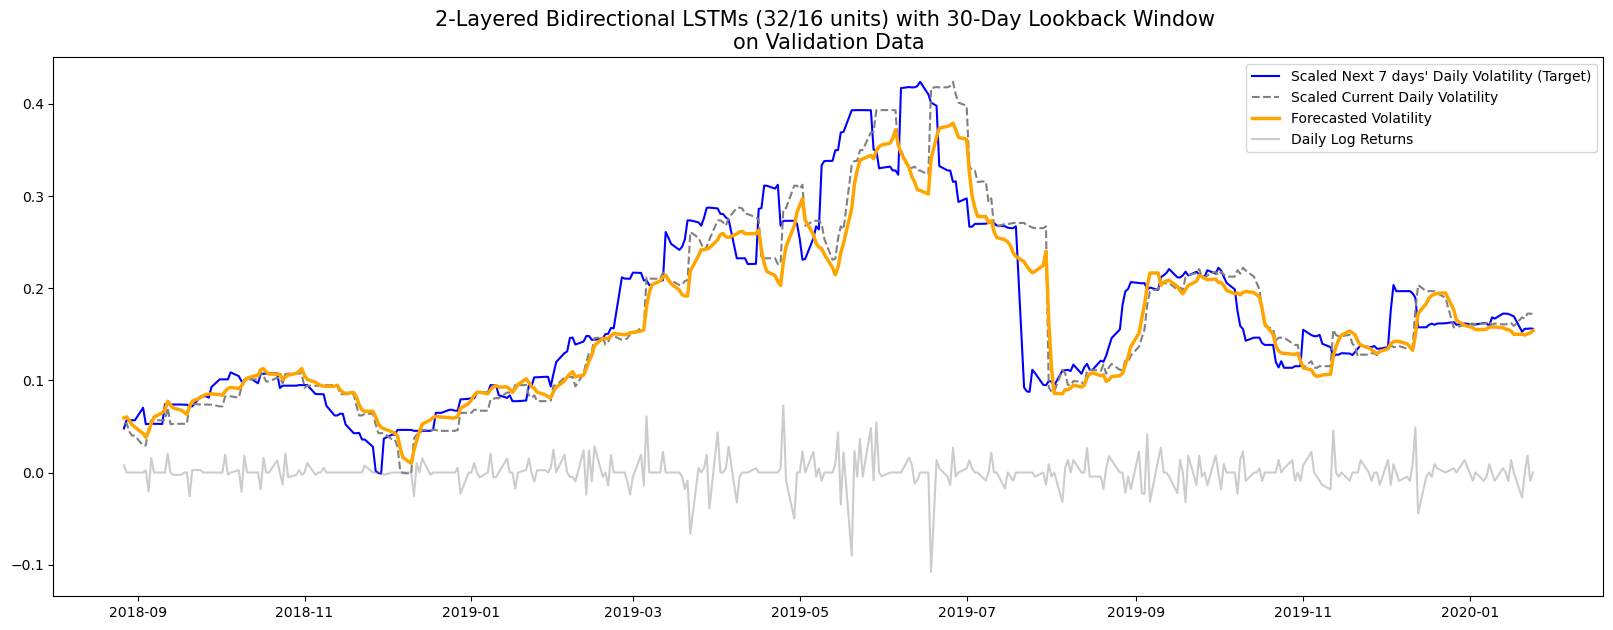

In [91]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, lstm_2_preds_scaled, 
          f"2-Layered Bidirectional LSTMs (32/16 units) with {n_past}-Day Lookback Window")

In [92]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, lstm_2_preds_scaled, 
         f"2 layers Bidirect LSTM (32/16 units) | n_past={n_past}")

Model  Validation RMSPE  \
0                                     Mean Baseline         28.954222   
1                     Random Walk Naive Forecasting          4.742650   
2          GARCH(1,1) | Constant Mean | Normal Dist          4.243133   
3                 LSTM 1 layer 20 units | n_past=14          8.020711   
4  2 layers Bidirect LSTM (32/16 units) | n_past=30          5.731809   

   Validation RMSE  
0         0.137538  
1         0.044705  
2         0.135375  
3         0.047053  
4         0.041381

### BTS SINI

BEST RESULT SO FAR

### multivariate Long Short-Term Memory (LSTM)
(Reference: Geron(2019))

There's a class of Neural Networks called Recurrent Neural Networks (RNN) that can "predict the future". RNN works well with time series data, such as stock prices, and can even process sentences, documents, audio samples as inputs. Another application of RNN is in autonomic driving systems, where they're used to anticipate vehicle trajectories and help avoid accidents.

In [93]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
from decimal import Decimal

## COBA MULTI

In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1524 entries, 2014-02-17 to 2020-03-06
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Open         1524 non-null   float64
 1   High         1524 non-null   float64
 2   Low          1524 non-null   float64
 3   Close        1524 non-null   float64
 4   Volume       1524 non-null   int64  
 5   returns      1524 non-null   float64
 6   log_returns  1524 non-null   float64
 7   vol_current  1524 non-null   float64
 8   vol_future   1524 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 151.4 KB


In [95]:
df.corr()

Open      High       Low     Close    Volume   returns  \
Open         1.000000  0.995274  0.996441  0.995669  0.109448 -0.001603   
High         0.995274  1.000000  0.991435  0.996027  0.127200  0.029595   
Low          0.996441  0.991435  1.000000  0.996079  0.088896  0.015253   
Close        0.995669  0.996027  0.996079  1.000000  0.103905  0.051156   
Volume       0.109448  0.127200  0.088896  0.103905  1.000000 -0.000753   
returns     -0.001603  0.029595  0.015253  0.051156 -0.000753  1.000000   
log_returns  0.003381  0.033218  0.021586  0.056109 -0.008108  0.998551   
vol_current -0.368062 -0.351771 -0.382502 -0.364100  0.012469  0.021286   
vol_future  -0.373539 -0.355425 -0.388107 -0.369922  0.012387  0.037191   

             log_returns  vol_current  vol_future  
Open            0.003381    -0.368062   -0.373539  
High            0.033218    -0.351771   -0.355425  
Low             0.021586    -0.382502   -0.388107  
Close           0.056109    -0.364100   -0.369922  
Volume         -0.008108     0.012469    0.012387  
returns         0.998551     0.021286    0.037191  
log_returns     1.000000     0.008613    0.023582  
vol_current     0.008613     1.000000    0.861113  
vol_future      0.023582     0.861113    1.000000

### Feature Scaling

In [96]:
df['HL_sprd'] =((df.High - df.Low) / df.Close)
df['CO_sprd'] =(df.Close - df.Open) / df.Open
df['Volume']  =(df.Volume)

In [97]:
df.head()

Open         High          Low        Close  Volume  \
Date                                                                     
2014-02-17  1554.188080  1569.132196  1494.411615  1535.507935   66700   
2014-02-18  1606.492486  1606.492486  1535.507935  1535.507935    6500   
2014-02-19  1587.812341  1587.812341  1535.507935  1535.507935    7000   
2014-02-20  1539.243951  1542.979980  1539.243951  1542.979980    1200   
2014-02-21  1546.716174  1554.188232  1546.716174  1554.188232     900   

             returns  log_returns  vol_current  vol_future   HL_sprd   CO_sprd  
Date                                                                            
2014-02-17 -3.294120    -0.033496     0.026888    0.020817  0.048662 -0.012019  
2014-02-18  0.000000     0.000000     0.025528    0.020836  0.046229 -0.044186  
2014-02-19  0.000000     0.000000     0.023947    0.019169  0.034063 -0.032941  
2014-02-20  0.486617     0.004854     0.023543    0.019246  0.002421  0.002427  
2014-02-21  0.726403     0.007238     0.021771    0.012603  0.004808  0.004831

In [98]:

from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [99]:
num_features = ['HL_sprd', 'CO_sprd', 'Volume', 'vol_current']

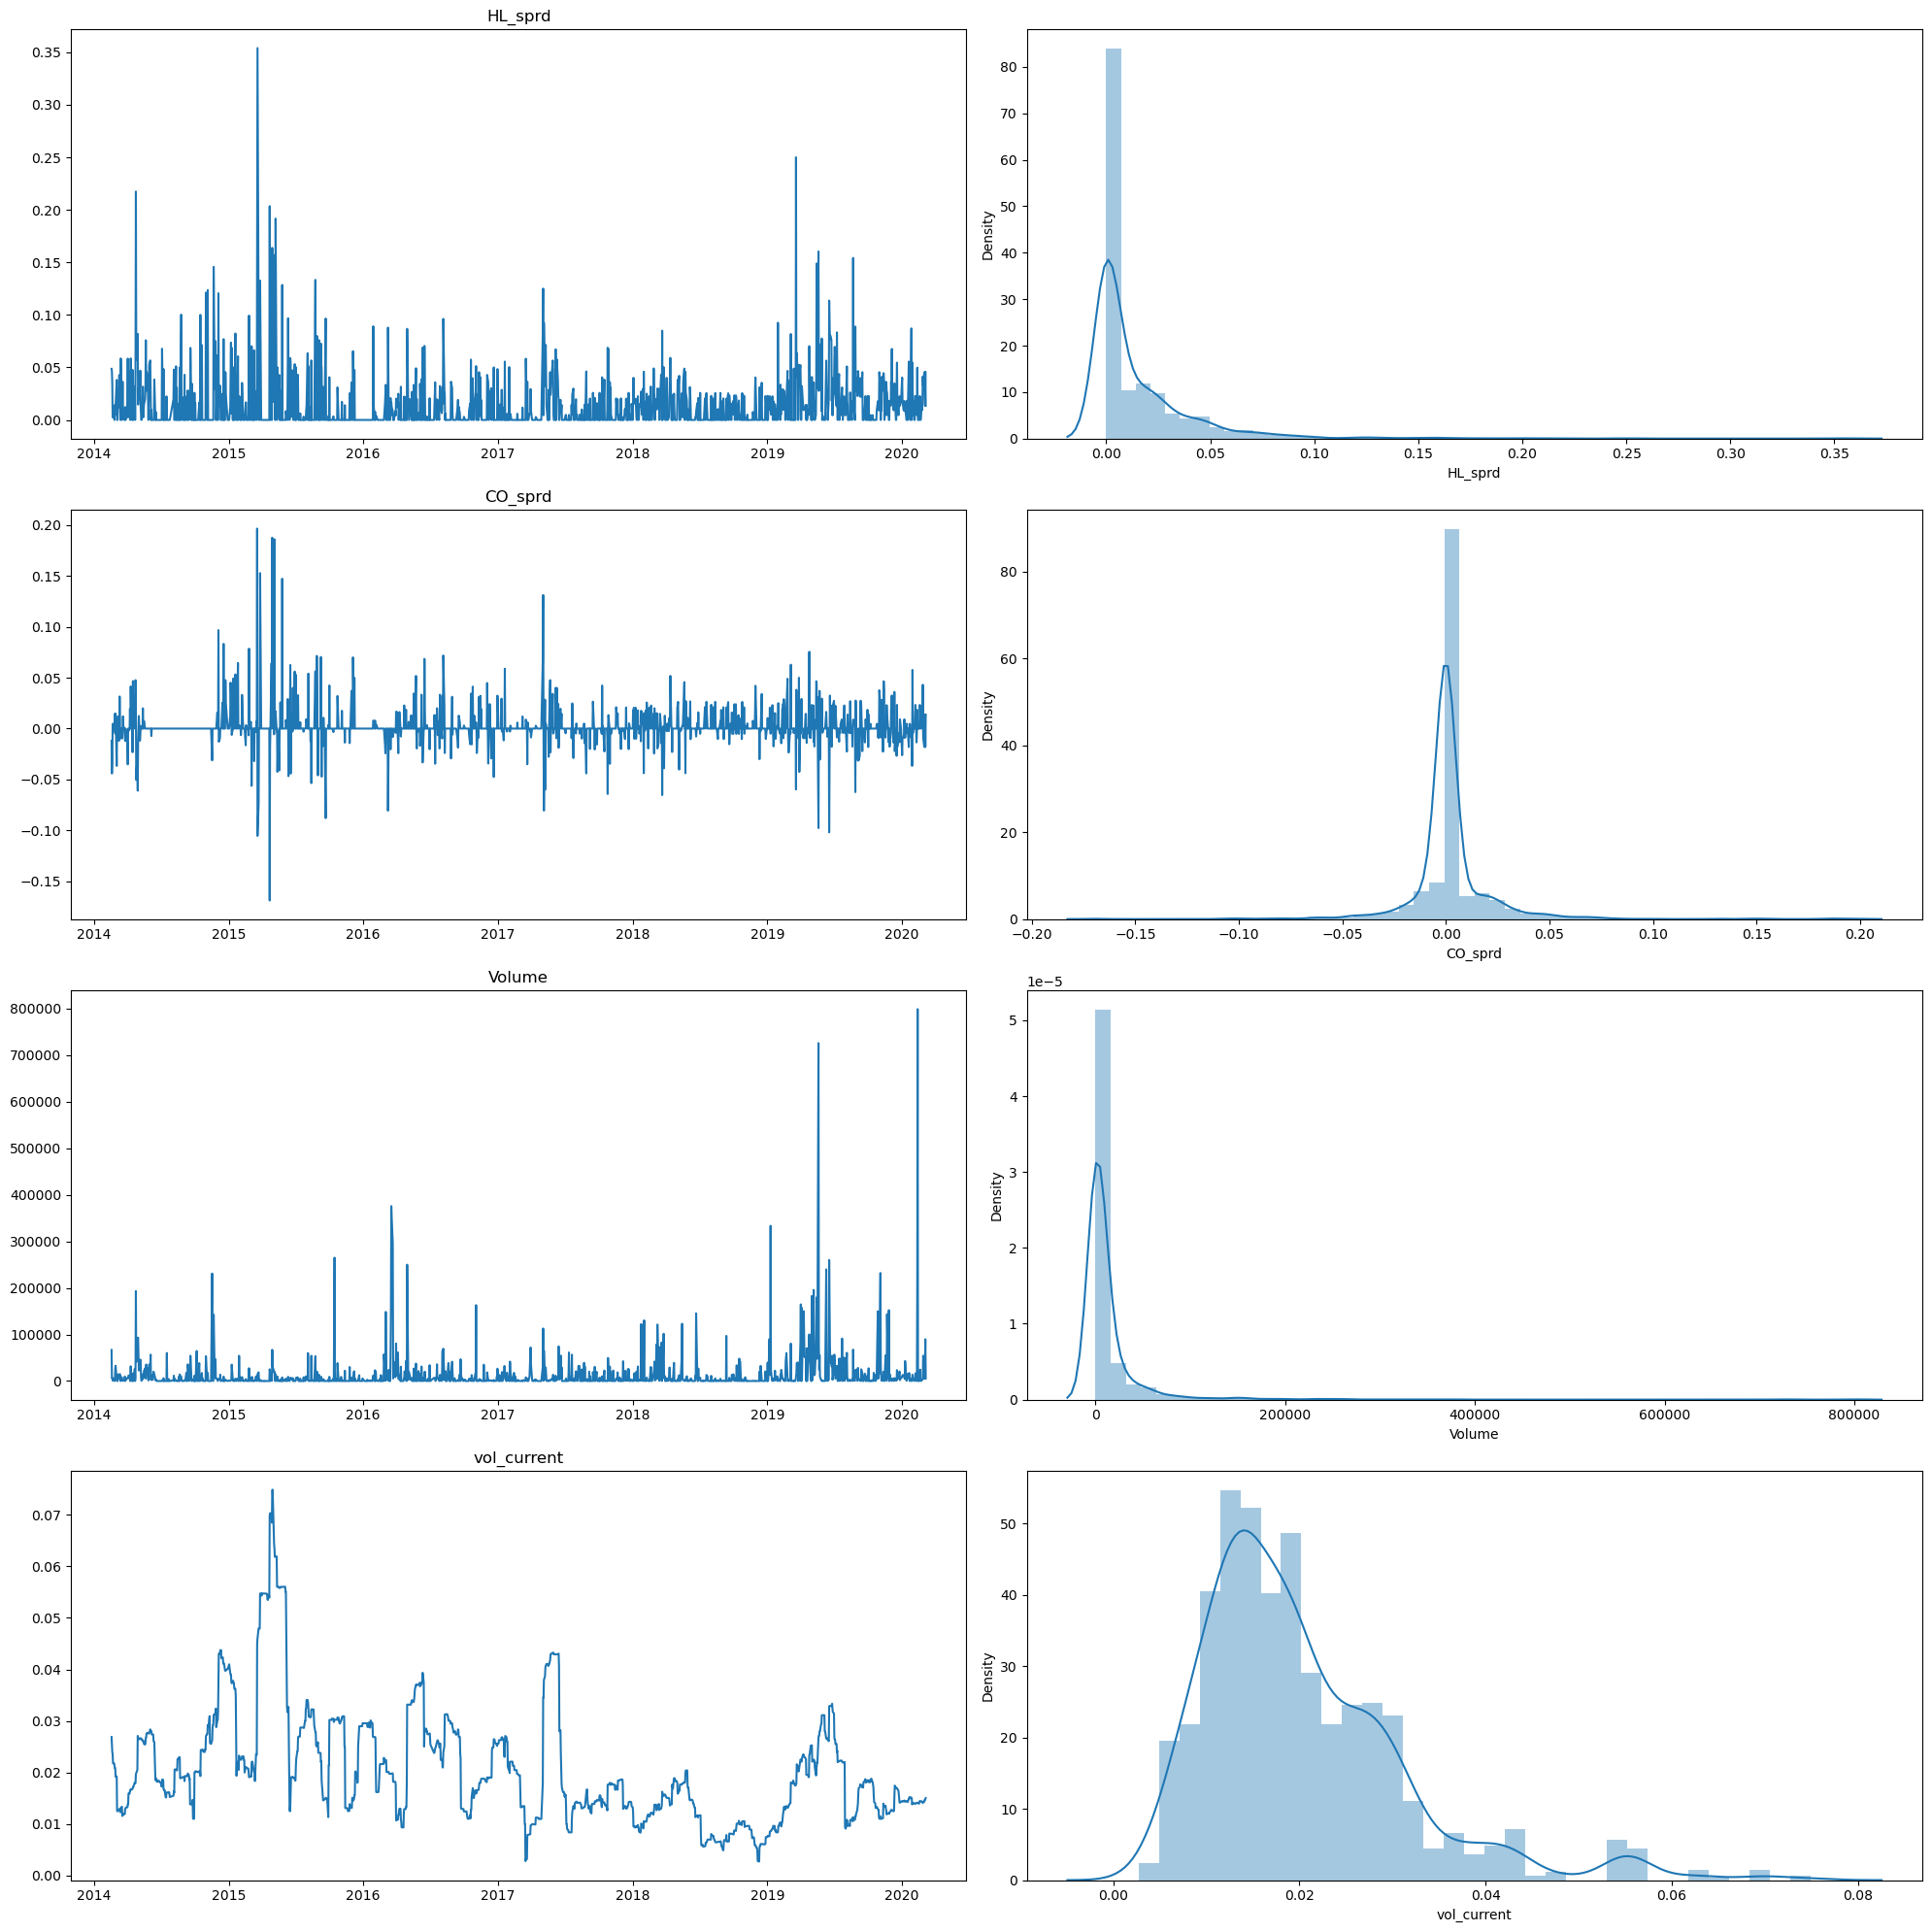

In [100]:
# PLOT EACH NUMERICAL COLUMN
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20,20))

for i, c in enumerate(num_features):
    ax1, ax2 = axes[i][0], axes[i][1]
    ax1.plot(df[c])
    ax1.set_title(c)

    sns.distplot(df[c], ax=ax2)

plt.tight_layout()
plt.show();

In [101]:
cols_to_scale = ['HL_sprd', 'CO_sprd', 'Volume']

# FITTING SCALER TO TRAINING DATA
scaler = MinMaxScaler()
scaler = scaler.fit(df.loc[train_idx][cols_to_scale])

# TRANSFORMING TRAINING DATAFRAME
num_train_dt_scaled = scaler.transform(df.loc[train_idx][cols_to_scale])
num_train_df_scaled = pd.DataFrame(num_train_dt_scaled, 
                                   columns=cols_to_scale,
                                   index=train_idx) 
num_train_df_scaled = pd.concat([num_train_df_scaled, df.vol_current[train_idx]], axis=1)

# TRANSFORMING VALIDATION DATAFRAME
num_val_dt_scaled = scaler.transform(df.loc[val_idx][cols_to_scale])
num_val_df_scaled = pd.DataFrame(num_val_dt_scaled, 
                                 columns=cols_to_scale,
                                 index=val_idx) 
num_val_df_scaled = pd.concat([num_val_df_scaled, df.vol_current[val_idx]], axis=1)

# TRANSFORMING TEST DATAFRAME
num_test_dt_scaled = scaler.transform(df.loc[test_idx][cols_to_scale])
num_test_df_scaled = pd.DataFrame(num_test_dt_scaled, 
                                  columns=cols_to_scale,
                                  index=test_idx) 
num_test_df_scaled = pd.concat([num_test_df_scaled, df.vol_current[test_idx]], axis=1)


In [102]:
df=pd.DataFrame(scaler.fit_transform(df),
            columns=df.columns, index=df.index)

In [103]:
df.head()

Open      High       Low     Close    Volume   returns  \
Date                                                                     
2014-02-17  0.481648  0.439070  0.450169  0.464287  0.083469  0.405555   
2014-02-18  0.521387  0.464350  0.482170  0.464287  0.008134  0.480182   
2014-02-19  0.507194  0.451710  0.482170  0.464287  0.008760  0.480182   
2014-02-20  0.470293  0.421374  0.485079  0.469925  0.001502  0.491206   
2014-02-21  0.475971  0.428958  0.490898  0.478383  0.001126  0.496638   

            log_returns  vol_current  vol_future   HL_sprd   CO_sprd  
Date                                                                  
2014-02-17     0.460251     0.334904    0.250781  0.137470  0.429385  
2014-02-18     0.535561     0.316065    0.251048  0.130596  0.341431  
2014-02-19     0.535561     0.294159    0.227945  0.096229  0.372178  
2014-02-20     0.546476     0.288553    0.229019  0.006840  0.468886  
2014-02-21     0.551834     0.264006    0.136971  0.013582  0.475459

In [104]:
num_train_df_scaled.head()

HL_sprd   CO_sprd    Volume  vol_current
Date                                                 
2014-02-17  0.137470  0.429385  0.177488     0.026888
2014-02-18  0.130596  0.341431  0.017296     0.025528
2014-02-19  0.096229  0.372178  0.018627     0.023947
2014-02-20  0.006840  0.468886  0.003193     0.023543
2014-02-21  0.013582  0.475459  0.002395     0.021771

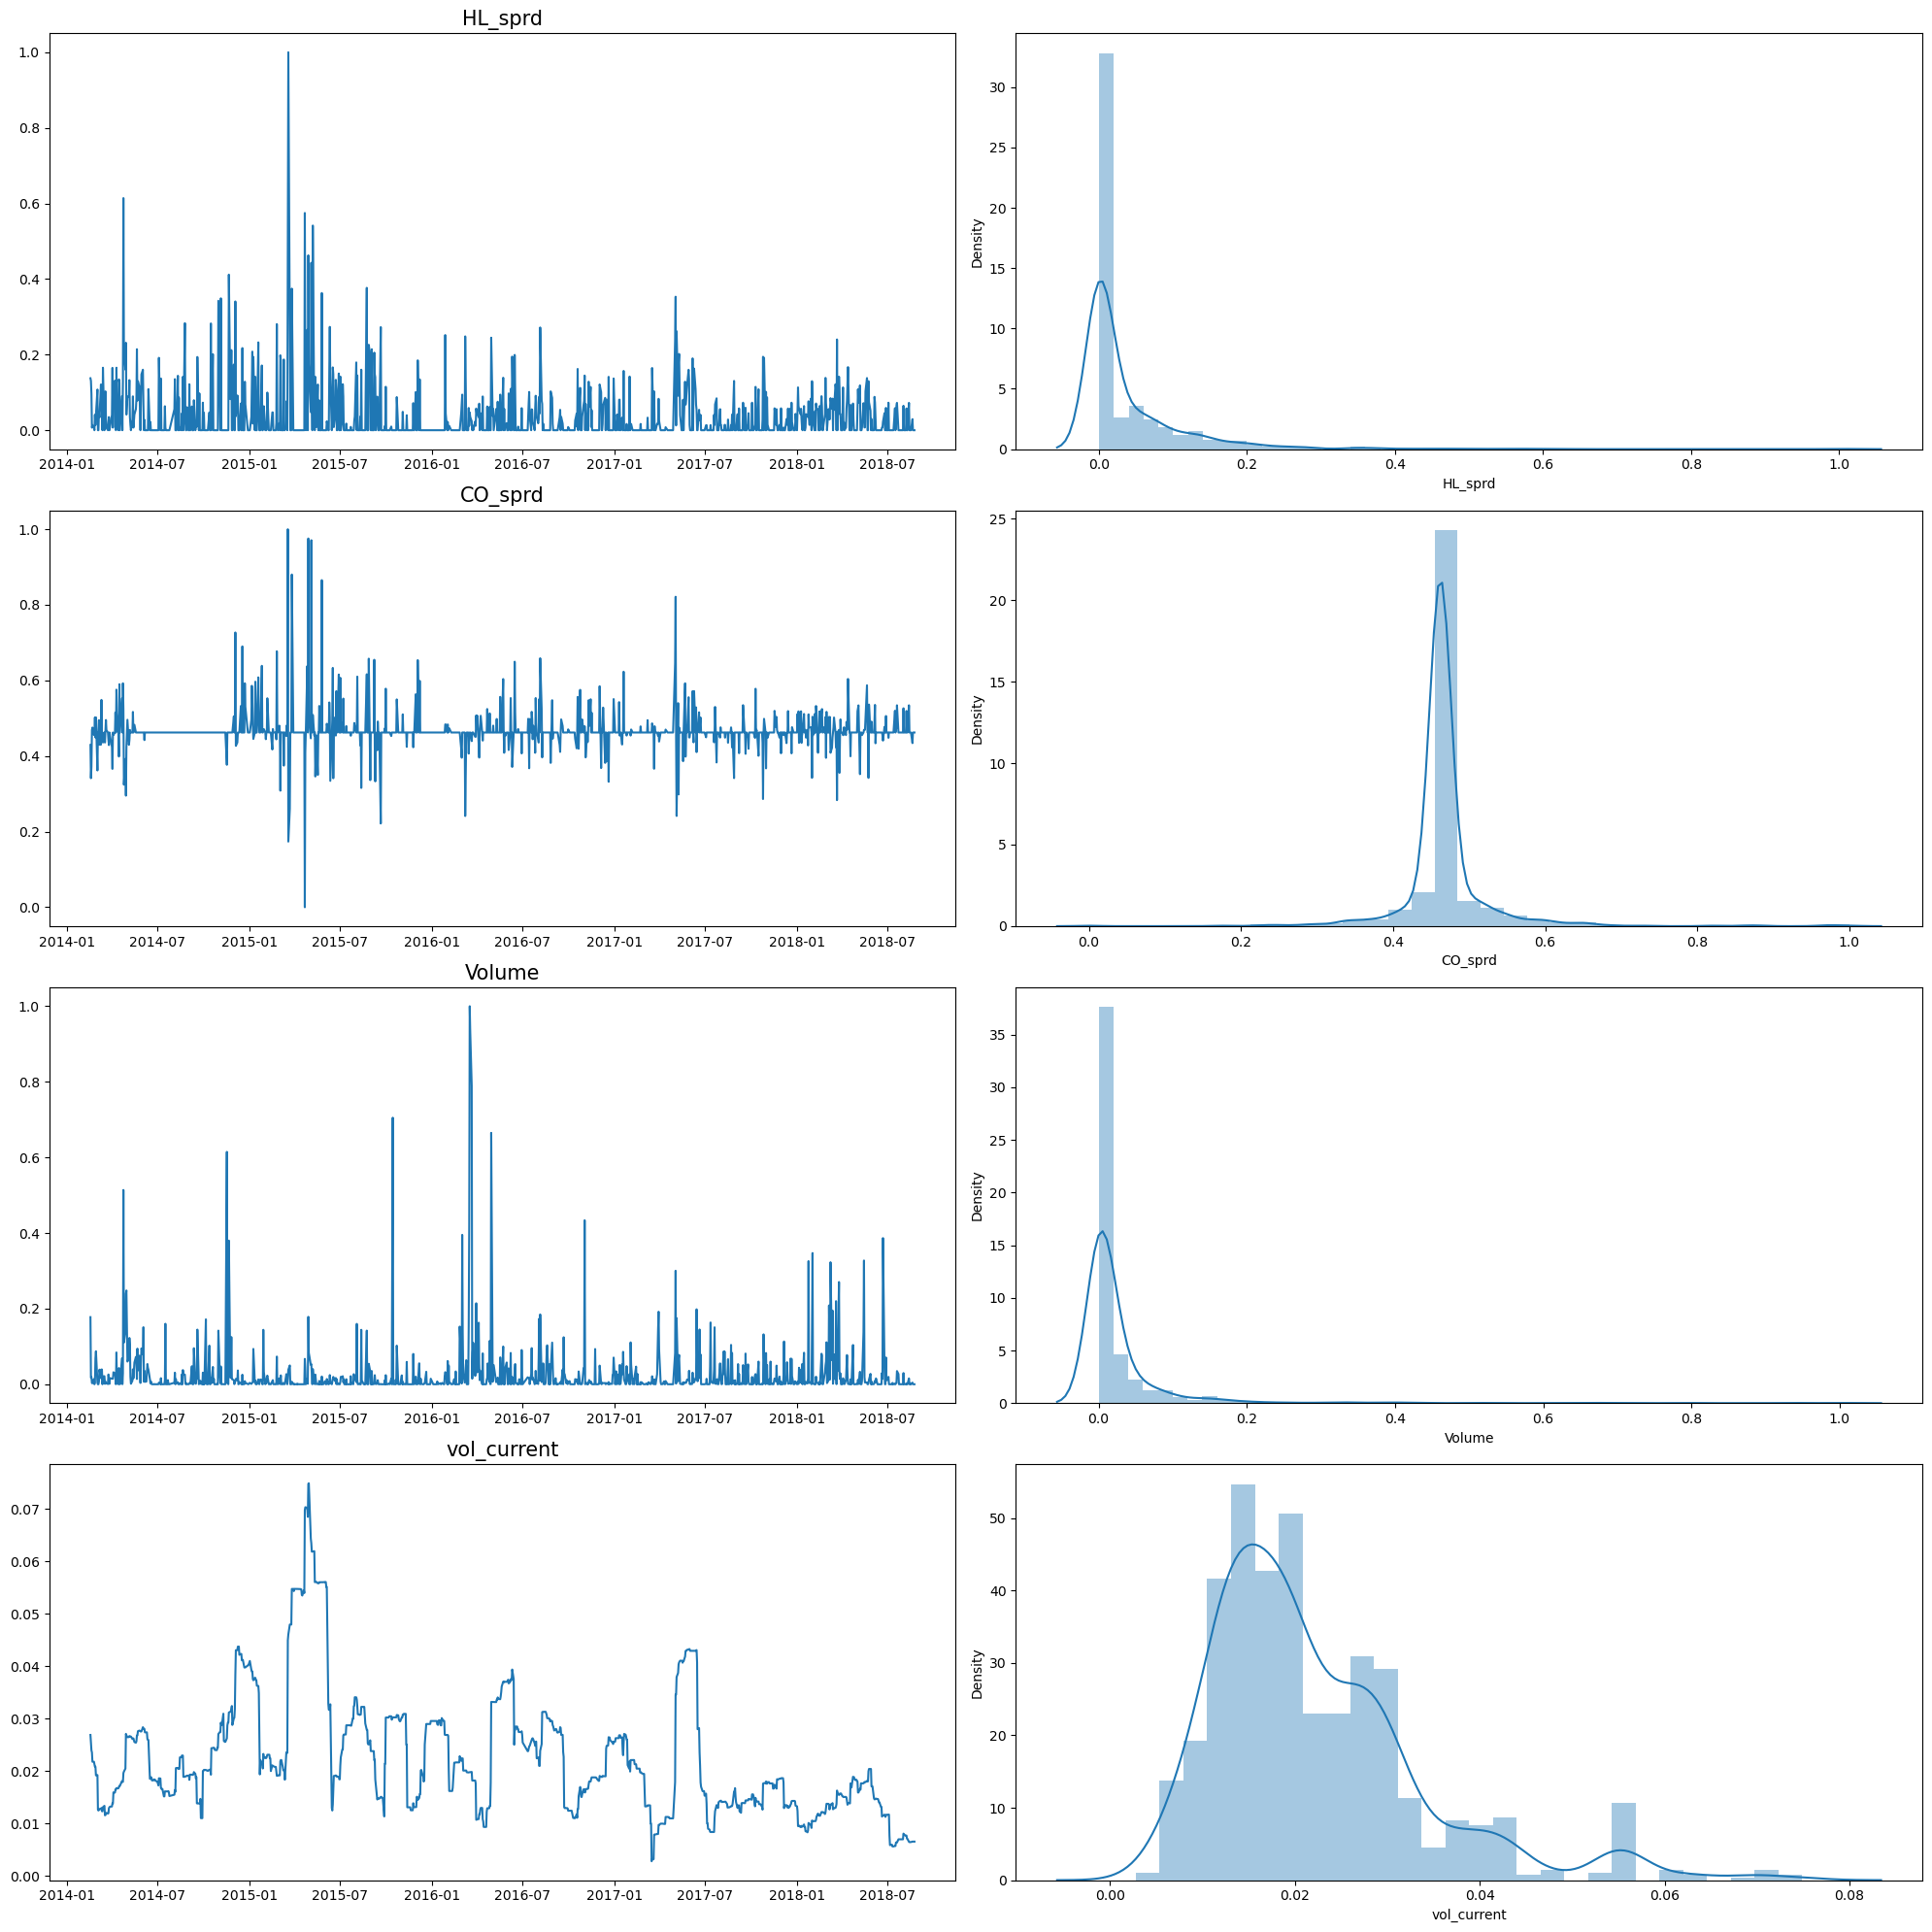

In [105]:
# PLOT NUMERICAL COLUMNS AFTER NORMALIZATION
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20,20))

for i, c in enumerate(num_features):
    ax1, ax2 = axes[i][0], axes[i][1]
    ax1.plot(num_train_df_scaled[c])
    ax1.set_title(c, fontsize=15)

    sns.distplot(num_train_df_scaled[c], ax=ax2)

plt.tight_layout()
plt.savefig('scaled_num_feats.jpg', dpi=300, bbox_inches='tight')
plt.show();

In [106]:
# COMBINING TRAIN / VALIDATION / TEST INPUTS INTO 1 DATAFRAME
input_df = pd.concat([num_train_df_scaled, num_val_df_scaled, num_test_df_scaled], axis=0)

In [107]:
# CREATE ANOTHER FORECASTING FUNCTION ON VALIDATION SET
# SPECIFICALLY FOR MULTIVARIATE 
def multi_val_forecast(model):
    forecast = []
    idx = df.index

    # ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
    for i in range(len(val_idx)):
        # GET THE DATA AT THE PREVIOUS n_past TIME STEPS
        # (including current value)
        from_idx = idx[split_time_1 + i - n_past + 1]
        to_idx = idx[split_time_1 + i]
        pred = model.predict(input_df[from_idx:to_idx].values[np.newaxis])
        forecast.append(pred)

    forecast = np.array(forecast)[:, 0, 0]
    preds = pd.Series(forecast, index=val_idx)
    preds_scaled = pd.Series(scaler_vol.transform(preds.values.reshape(-1,1))[:,0],
                                index=val_idx)

    return preds_scaled

In [108]:
tf.keras.backend.clear_session()

n_past = 30
batch_size = 64
n_dims = num_train_df_scaled.shape[1]

mat_X_train, mat_y_train = windowed_dataset(num_train_df_scaled, y_train, n_past)
mat_X_val, mat_y_val = windowed_dataset(num_val_df_scaled, y_val, n_past)

# CONSTRUCTING MULTIVARIATE BIDIRECTIONAL LSTM NN
lstm_6 = tf.keras.models.Sequential([  
    tf.keras.layers.InputLayer(input_shape=[n_past, n_dims]),

    # ADDING 1st LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    # ADDING 2nd LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    # ADDING 3rd LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),

    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_6.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_6.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=20,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

lstm_6_res = lstm_6.fit(mat_X_train, mat_y_train, epochs=500,
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_data=(mat_X_val, mat_y_val),
                        verbose=1, batch_size=batch_size, shuffle=True)

Epoch 1/500
18/18 [==============================] - 11s 162ms/step - loss: 0.0018 - rmspe: 2.3111 - val_loss: 1.2407e-04 - val_rmspe: 0.8379
Epoch 2/500
18/18 [==============================] - 1s 43ms/step - loss: 2.6757e-04 - rmspe: 0.9266 - val_loss: 2.3183e-05 - val_rmspe: 0.4150
Epoch 3/500
18/18 [==============================] - 1s 39ms/step - loss: 1.3778e-04 - rmspe: 0.7236 - val_loss: 6.9998e-05 - val_rmspe: 0.7648
Epoch 4/500
18/18 [==============================] - 1s 39ms/step - loss: 1.1532e-04 - rmspe: 0.6550 - val_loss: 7.2316e-05 - val_rmspe: 0.7724
Epoch 5/500
18/18 [==============================] - 1s 39ms/step - loss: 1.0220e-04 - rmspe: 0.6549 - val_loss: 1.1758e-04 - val_rmspe: 0.9596
Epoch 6/500
18/18 [==============================] - 1s 39ms/step - loss: 9.2007e-05 - rmspe: 0.6166 - val_loss: 8.3653e-05 - val_rmspe: 0.8020
Epoch 7/500
18/18 [==============================] - 1s 38ms/step - loss: 8.6565e-05 - rmspe: 0.5686 - val_loss: 1.0910e-04 - val_rmspe: 0

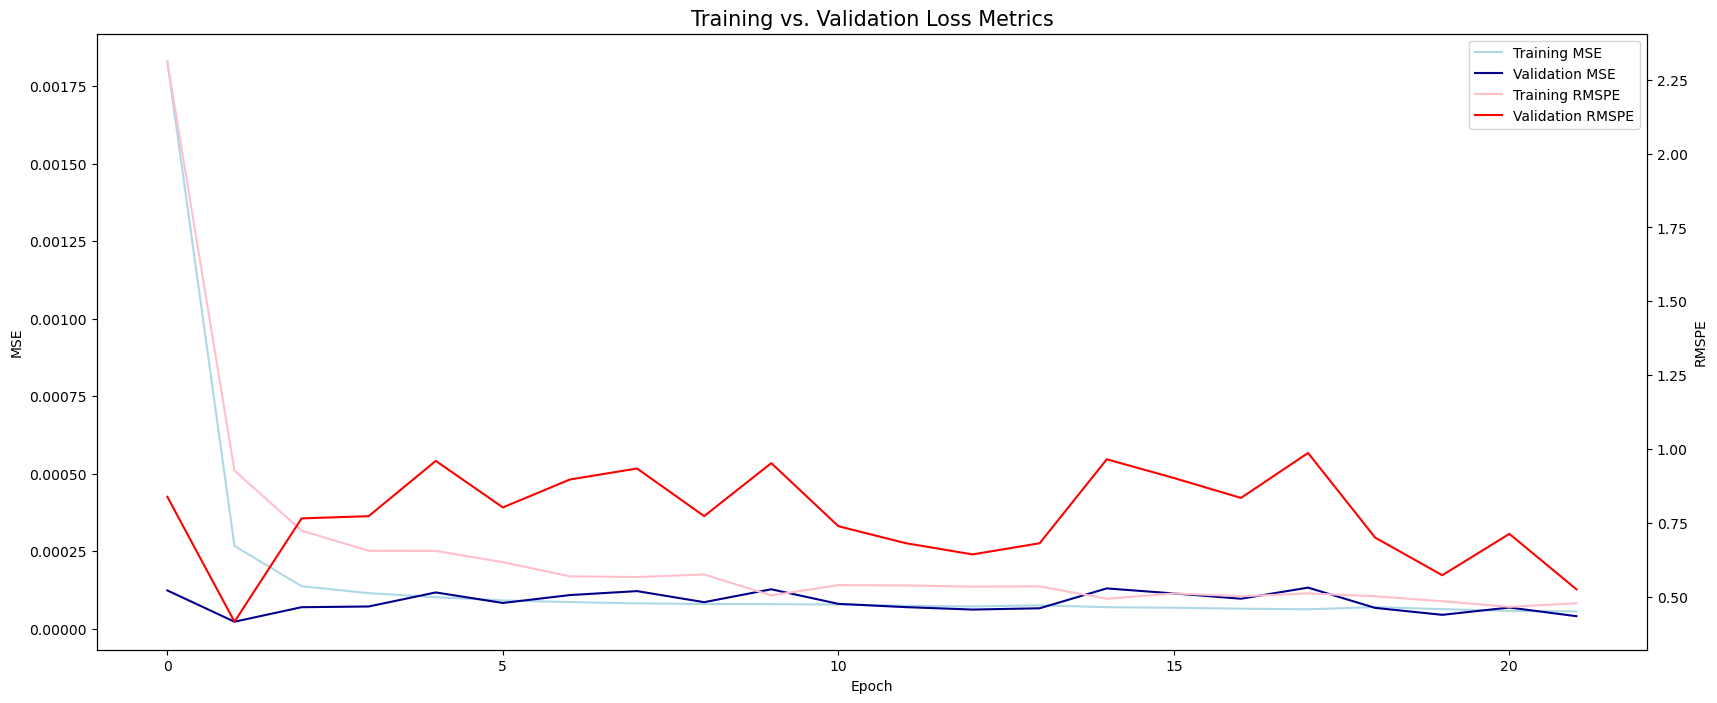

In [109]:
# VISUALIZING LEARNING CURVES
viz_train_val_metrics(lstm_6_res)

In [110]:
# MAKE PREDICTIONS ON VALIDATION SET
lstm_6_preds_scaled = multi_val_forecast(lstm_6)

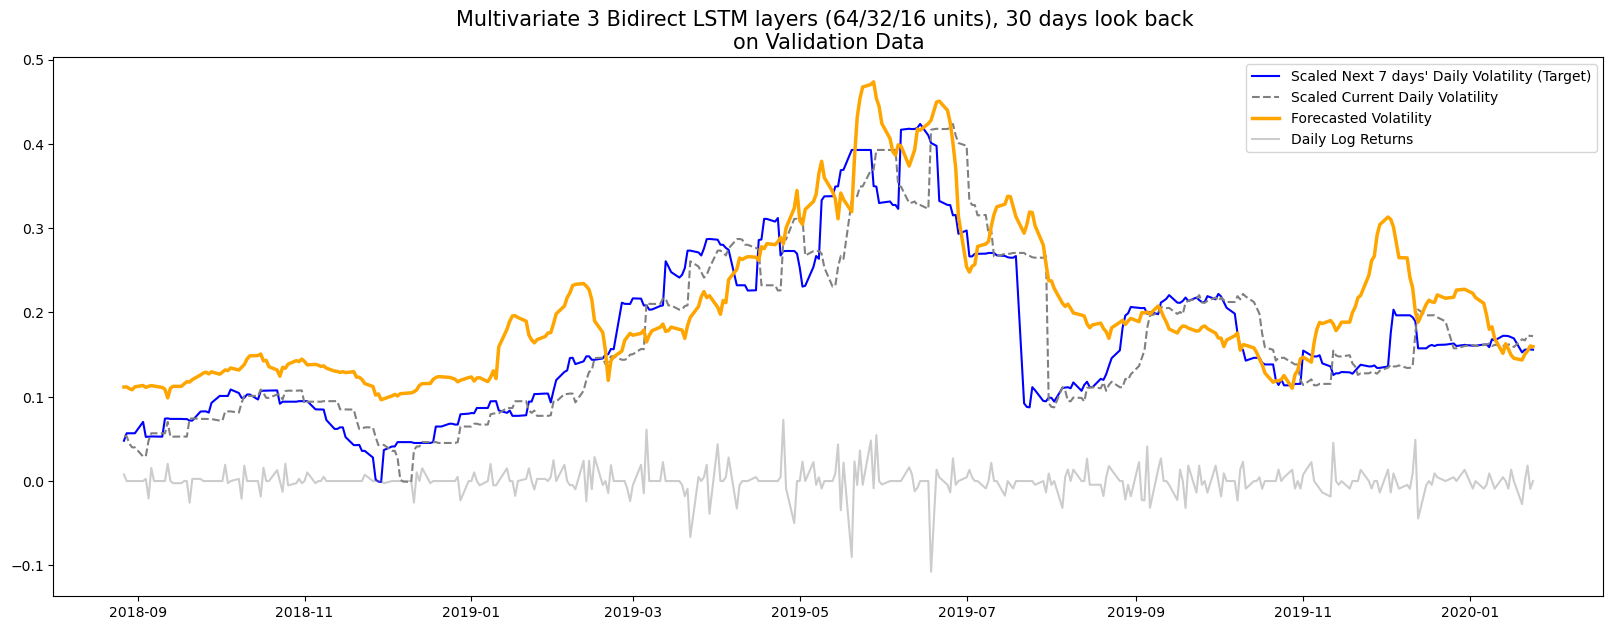

In [111]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, lstm_6_preds_scaled, 
          f"Multivariate 3 Bidirect LSTM layers (64/32/16 units), {n_past} days look back")

In [112]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, lstm_6_preds_scaled,
         f"Multivariate Bidirect LSTM 3 layers (64/32/16 units) | n_past={n_past}")

Model  \
0                                                     Mean Baseline   
1                                     Random Walk Naive Forecasting   
2                          GARCH(1,1) | Constant Mean | Normal Dist   
3                                 LSTM 1 layer 20 units | n_past=14   
4                  2 layers Bidirect LSTM (32/16 units) | n_past=30   
5  Multivariate Bidirect LSTM 3 layers (64/32/16 units) | n_past=30   

   Validation RMSPE  Validation RMSE  
0         28.954222         0.137538  
1          4.742650         0.044705  
2          4.243133         0.135375  
3          8.020711         0.047053  
4          5.731809         0.041381  
5         11.037557         0.065400

In [113]:
tf.keras.backend.clear_session()

n_past = 30
batch_size = 32
n_dims = num_train_df_scaled.shape[1]

mat_X_train, mat_y_train = windowed_dataset(num_train_df_scaled, y_train, n_past)
mat_X_val, mat_y_val = windowed_dataset(num_val_df_scaled, y_val, n_past)

# CONSTRUCTING MULTIVARIATE BIDIRECTIONAL LSTM NN
lstm_7 = tf.keras.models.Sequential([  
    tf.keras.layers.InputLayer(input_shape=[n_past, n_dims]),

    # ADDING 1st LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    # ADDING 2nd LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(10)),

    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_7.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_7.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=20,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

lstm_7_res = lstm_7.fit(mat_X_train, mat_y_train, epochs=250,
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_data=(mat_X_val, mat_y_val),
                        verbose=1, batch_size=batch_size, shuffle=True)

Epoch 1/250
35/35 [==============================] - 7s 55ms/step - loss: 2.0007e-04 - rmspe: 0.8244 - val_loss: 9.1427e-05 - val_rmspe: 0.7867
Epoch 2/250
35/35 [==============================] - 1s 18ms/step - loss: 8.0353e-05 - rmspe: 0.5742 - val_loss: 9.0264e-05 - val_rmspe: 0.8291
Epoch 3/250
35/35 [==============================] - 1s 19ms/step - loss: 7.5136e-05 - rmspe: 0.5553 - val_loss: 6.7275e-05 - val_rmspe: 0.6982
Epoch 4/250
35/35 [==============================] - 1s 19ms/step - loss: 6.1989e-05 - rmspe: 0.4978 - val_loss: 4.1827e-05 - val_rmspe: 0.5089
Epoch 5/250
35/35 [==============================] - 1s 18ms/step - loss: 5.9863e-05 - rmspe: 0.4836 - val_loss: 6.7998e-05 - val_rmspe: 0.6904
Epoch 6/250
35/35 [==============================] - 1s 17ms/step - loss: 5.4848e-05 - rmspe: 0.4609 - val_loss: 6.2555e-05 - val_rmspe: 0.6687
Epoch 7/250
35/35 [==============================] - 1s 17ms/step - loss: 5.2948e-05 - rmspe: 0.4307 - val_loss: 8.0766e-05 - val_rmspe:

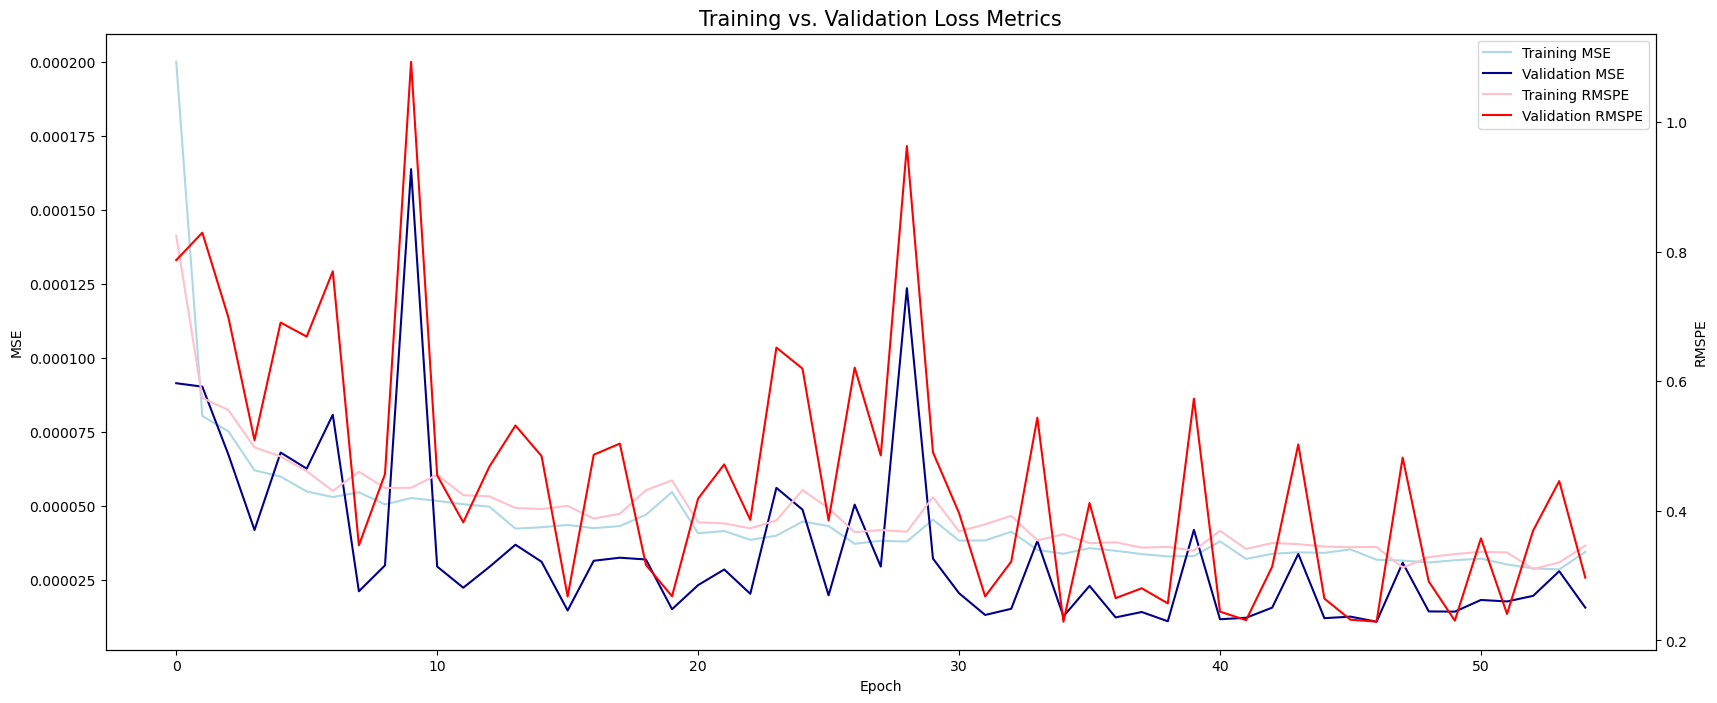

<Figure size 640x480 with 0 Axes>

In [114]:
# VISUALIZING LEARNING CURVES
viz_train_val_metrics(lstm_7_res)
plt.savefig('lstm_7_learning_curves.jpg', dpi=300, bbox_inches='tight')

In [115]:
# MAKE PREDICTIONS ON VALIDATION SET
lstm_7_preds_scaled = multi_val_forecast(lstm_7)

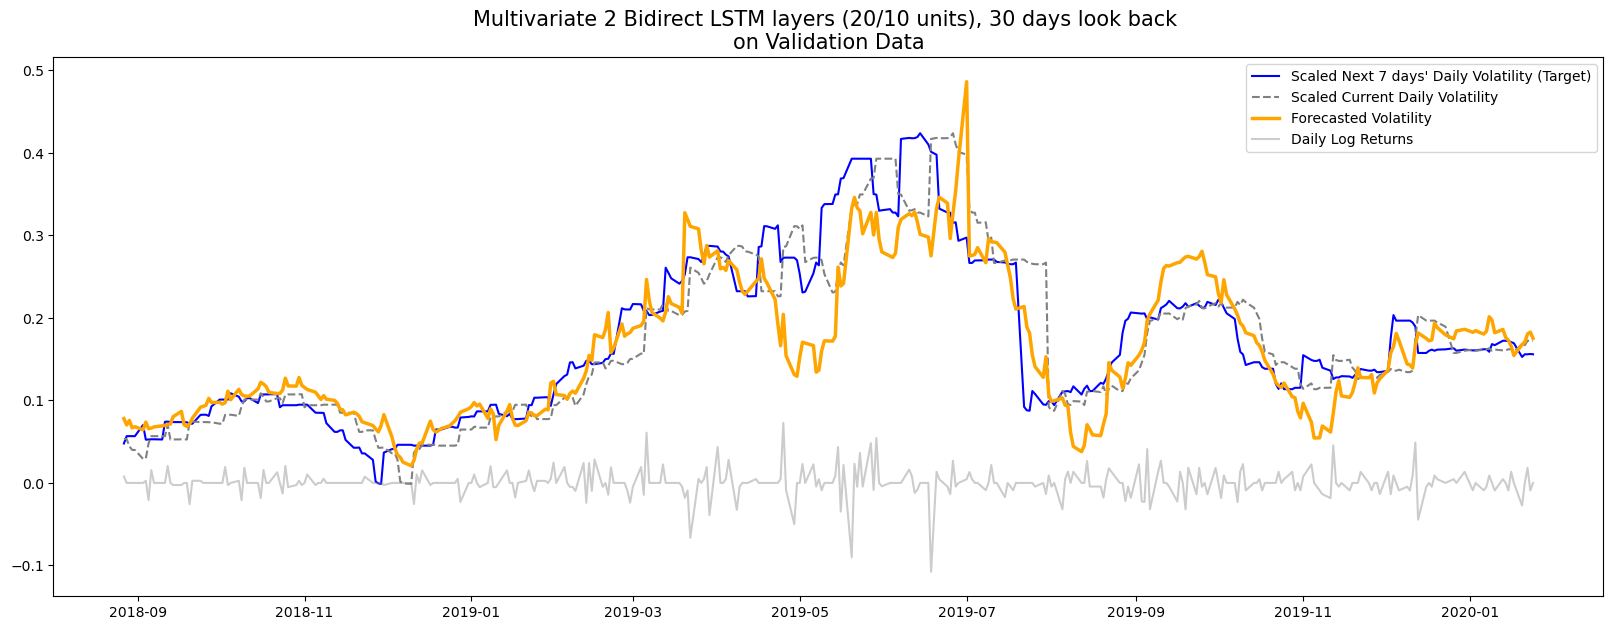

In [116]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, lstm_7_preds_scaled, 
          f"Multivariate 2 Bidirect LSTM layers (20/10 units), {n_past} days look back")
plt.savefig(os.path.join('lstm_7_preds.jpg'), dpi=300, bbox_inches='tight')
plt.show();

In [117]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, lstm_7_preds_scaled, 
         f"Multivariate 2 Bidirect LSTM layers (20/10 units) | n_past={n_past} | batch={batch_size}")

Model  \
0                                                             Mean Baseline   
1                                             Random Walk Naive Forecasting   
2                                  GARCH(1,1) | Constant Mean | Normal Dist   
3                                         LSTM 1 layer 20 units | n_past=14   
4                          2 layers Bidirect LSTM (32/16 units) | n_past=30   
5          Multivariate Bidirect LSTM 3 layers (64/32/16 units) | n_past=30   
6  Multivariate 2 Bidirect LSTM layers (20/10 units) | n_past=30 | batch=32   

   Validation RMSPE  Validation RMSE  
0         28.954222         0.137538  
1          4.742650         0.044705  
2          4.243133         0.135375  
3          8.020711         0.047053  
4          5.731809         0.041381  
5         11.037557         0.065400  
6          6.894590         0.047439

### FINAL

For this final model, I'll re-create the same architecture as model #5 (Multivariate 2 Bidirect LSTM layers (20/10 units) | n_past=30 | batch=64) and a lookback window n_past = 14 and batch_size = 64. However, I'll extend the training to include the validation set as well. This is important in time series data since the more recent time steps would most likely carry more relevant information for successful forecasting than data from a year ago.

In [118]:
# COMBINING TRAINING & VALIDATION SETS INTO 1
tv_df = pd.concat([num_train_df_scaled, num_val_df_scaled], axis=0)
tv_y = pd.concat([y_train, y_val], axis=0)

In [119]:
num_train_df_scaled

HL_sprd   CO_sprd    Volume  vol_current
Date                                                 
2014-02-17  0.137470  0.429385  0.177488     0.026888
2014-02-18  0.130596  0.341431  0.017296     0.025528
2014-02-19  0.096229  0.372178  0.018627     0.023947
2014-02-20  0.006840  0.468886  0.003193     0.023543
2014-02-21  0.013582  0.475459  0.002395     0.021771
...              ...       ...       ...          ...
2018-08-20  0.029275  0.434205  0.004258     0.006546
2018-08-21  0.000000  0.462250  0.000000     0.006546
2018-08-22  0.000000  0.462250  0.000000     0.006546
2018-08-23  0.000000  0.462250  0.000000     0.006546
2018-08-24  0.000000  0.462250  0.000000     0.006546

[1129 rows x 4 columns]

In [120]:
df

Open      High       Low     Close    Volume   returns  \
Date                                                                     
2014-02-17  0.481648  0.439070  0.450169  0.464287  0.083469  0.405555   
2014-02-18  0.521387  0.464350  0.482170  0.464287  0.008134  0.480182   
2014-02-19  0.507194  0.451710  0.482170  0.464287  0.008760  0.480182   
2014-02-20  0.470293  0.421374  0.485079  0.469925  0.001502  0.491206   
2014-02-21  0.475971  0.428958  0.490898  0.478383  0.001126  0.496638   
...              ...       ...       ...       ...       ...       ...   
2020-03-02  0.862247  0.767922  0.815668  0.828833  0.041422  0.543404   
2020-03-03  0.834489  0.755561  0.829893  0.801262  0.006007  0.439178   
2020-03-04  0.813669  0.743199  0.837005  0.828833  0.055938  0.521942   
2020-03-05  0.841428  0.786463  0.837005  0.808155  0.112251  0.449429   
2020-03-06  0.813669  0.743199  0.837005  0.828833  0.006883  0.511358   

            log_returns  vol_current  vol_future   HL_sprd   CO_sprd  
Date                                                                  
2014-02-17     0.460251     0.334904    0.250781  0.137470  0.429385  
2014-02-18     0.535561     0.316065    0.251048  0.130596  0.341431  
2014-02-19     0.535561     0.294159    0.227945  0.096229  0.372178  
2014-02-20     0.546476     0.288553    0.229019  0.006840  0.468886  
2014-02-21     0.551834     0.264006    0.136971  0.013582  0.475459  
...                 ...          ...         ...       ...       ...  
2020-03-02     0.597446     0.160542    0.334864  0.127828  0.413639  
2020-03-03     0.494495     0.166037    0.315332  0.078111  0.412760  
2020-03-04     0.576628     0.165987    0.315138  0.038348  0.499878  
2020-03-05     0.504832     0.167661    0.318398  0.129587  0.412983  
2020-03-06     0.566291     0.170651    0.363172  0.038348  0.499878  

[1524 rows x 11 columns]

In [121]:
num_val_df_scaled

HL_sprd   CO_sprd    Volume  vol_current
Date                                                 
2018-08-27  0.072622  0.483501  0.013039     0.006633
2018-08-28  0.000000  0.462250  0.000000     0.006633
2018-08-29  0.050835  0.512355  0.000532     0.005989
2018-08-30  0.000000  0.462250  0.000000     0.005682
2018-08-31  0.000000  0.462250  0.000000     0.005682
...              ...       ...       ...          ...
2020-01-20  0.156944  0.412535  0.019691     0.014926
2020-01-21  0.065394  0.462250  0.045769     0.014831
2020-01-22  0.038523  0.462250  0.001597     0.015218
2020-01-23  0.025917  0.474850  0.009047     0.015220
2020-01-24  0.000000  0.462250  0.000532     0.015196

[365 rows x 4 columns]

In [122]:
tf.keras.backend.clear_session()

n_past = 30
batch_size = 64
n_dims = num_train_df_scaled.shape[1]

mat_X_tv, mat_y_tv = windowed_dataset(tv_df, tv_y, n_past)
mat_X_test, mat_y_test = windowed_dataset(num_test_df_scaled, y_test, n_past)

# CONSTRUCTING MULTIVARIATE BIDIRECTIONAL LSTM NN
lstm_final = tf.keras.models.Sequential([  
    tf.keras.layers.InputLayer(input_shape=[n_past, n_dims]),   

    # ADDING 1st LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    # ADDING 1st LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(10)),

    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_final.compile(loss='mse', 
                    optimizer="adam", 
                    metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_final.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=20,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

lstm_final_res = lstm_final.fit(mat_X_tv, mat_y_tv, epochs=500,
                                validation_split=0.15,
                                callbacks=[checkpoint_cb, early_stopping_cb],
                                verbose=1, batch_size=batch_size, shuffle=True)


Epoch 1/500
20/20 [==============================] - 8s 96ms/step - loss: 5.0984e-04 - rmspe: 1.6512 - val_loss: 6.7840e-04 - val_rmspe: 0.9163
Epoch 2/500
20/20 [==============================] - 0s 21ms/step - loss: 1.6477e-04 - rmspe: 0.9339 - val_loss: 1.4824e-04 - val_rmspe: 0.5218
Epoch 3/500
20/20 [==============================] - 0s 19ms/step - loss: 9.1525e-05 - rmspe: 0.6721 - val_loss: 7.9019e-05 - val_rmspe: 0.5608
Epoch 4/500
20/20 [==============================] - 0s 20ms/step - loss: 7.2178e-05 - rmspe: 0.5465 - val_loss: 7.2860e-05 - val_rmspe: 0.5384
Epoch 5/500
20/20 [==============================] - 0s 18ms/step - loss: 7.0125e-05 - rmspe: 0.5301 - val_loss: 7.6807e-05 - val_rmspe: 0.5492
Epoch 6/500
20/20 [==============================] - 0s 22ms/step - loss: 6.7356e-05 - rmspe: 0.4959 - val_loss: 5.0238e-05 - val_rmspe: 0.4143
Epoch 7/500
20/20 [==============================] - 0s 19ms/step - loss: 6.6387e-05 - rmspe: 0.4992 - val_loss: 1.3077e-04 - val_rmspe:

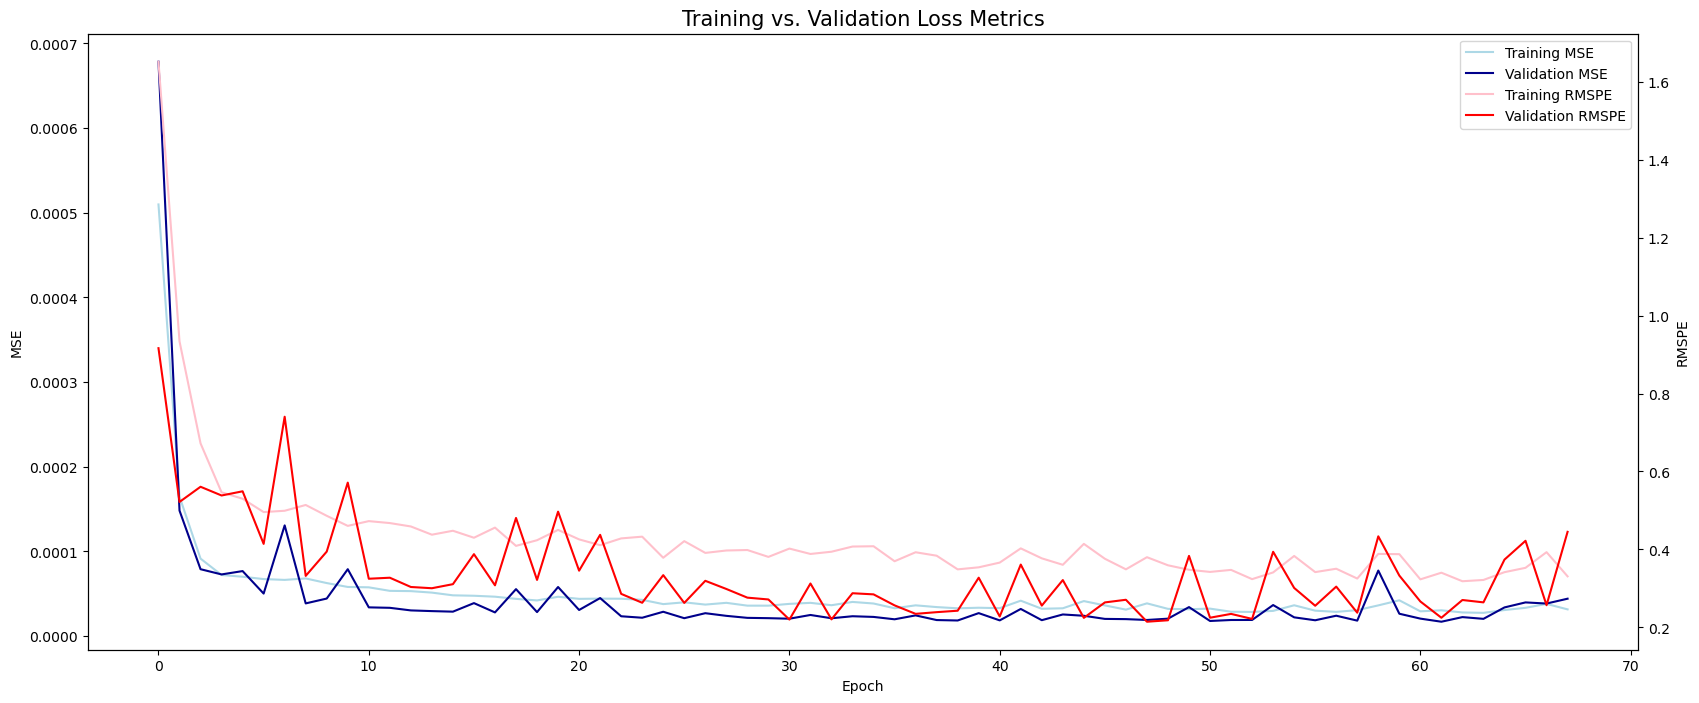

<Figure size 640x480 with 0 Axes>

In [123]:
viz_train_val_metrics(lstm_final_res)
plt.savefig(os.path.join('final_lstm_learning_curves.jpg'), dpi=300, bbox_inches='tight')

In [124]:
df

Open      High       Low     Close    Volume   returns  \
Date                                                                     
2014-02-17  0.481648  0.439070  0.450169  0.464287  0.083469  0.405555   
2014-02-18  0.521387  0.464350  0.482170  0.464287  0.008134  0.480182   
2014-02-19  0.507194  0.451710  0.482170  0.464287  0.008760  0.480182   
2014-02-20  0.470293  0.421374  0.485079  0.469925  0.001502  0.491206   
2014-02-21  0.475971  0.428958  0.490898  0.478383  0.001126  0.496638   
...              ...       ...       ...       ...       ...       ...   
2020-03-02  0.862247  0.767922  0.815668  0.828833  0.041422  0.543404   
2020-03-03  0.834489  0.755561  0.829893  0.801262  0.006007  0.439178   
2020-03-04  0.813669  0.743199  0.837005  0.828833  0.055938  0.521942   
2020-03-05  0.841428  0.786463  0.837005  0.808155  0.112251  0.449429   
2020-03-06  0.813669  0.743199  0.837005  0.828833  0.006883  0.511358   

            log_returns  vol_current  vol_future   HL_sprd   CO_sprd  
Date                                                                  
2014-02-17     0.460251     0.334904    0.250781  0.137470  0.429385  
2014-02-18     0.535561     0.316065    0.251048  0.130596  0.341431  
2014-02-19     0.535561     0.294159    0.227945  0.096229  0.372178  
2014-02-20     0.546476     0.288553    0.229019  0.006840  0.468886  
2014-02-21     0.551834     0.264006    0.136971  0.013582  0.475459  
...                 ...          ...         ...       ...       ...  
2020-03-02     0.597446     0.160542    0.334864  0.127828  0.413639  
2020-03-03     0.494495     0.166037    0.315332  0.078111  0.412760  
2020-03-04     0.576628     0.165987    0.315138  0.038348  0.499878  
2020-03-05     0.504832     0.167661    0.318398  0.129587  0.412983  
2020-03-06     0.566291     0.170651    0.363172  0.038348  0.499878  

[1524 rows x 11 columns]

In [125]:
# MAKING PREDICTIONS ON TEST SET
idx = df.index
forecast = []

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(test_idx)):
    # GET THE DATA AT THE PREVIOUS n_past TIME STEPS
    # (including current value)
    from_idx = idx[split_time_2 + i - n_past + 1]
    to_idx = idx[split_time_2 + i]
    pred = lstm_final.predict(input_df[from_idx:to_idx].values[np.newaxis])
    forecast.append(pred)

forecast = np.array(forecast)[:, 0, 0]
y_test_preds = pd.Series(forecast, index=test_idx)

In [126]:
y_test_preds

Date
2020-01-27    0.018346
2020-01-28    0.016779
2020-01-29    0.018293
2020-01-30    0.018368
2020-01-31    0.016576
2020-02-03    0.015650
2020-02-04    0.014587
2020-02-05    0.015314
2020-02-06    0.015547
2020-02-07    0.015244
2020-02-10    0.015772
2020-02-11    0.015227
2020-02-12    0.016654
2020-02-13    0.009825
2020-02-14    0.008729
2020-02-17    0.008717
2020-02-18    0.010205
2020-02-19    0.011379
2020-02-20    0.011614
2020-02-21    0.011877
2020-02-24    0.012246
2020-02-25    0.011898
2020-02-26    0.012611
2020-02-27    0.012825
2020-02-28    0.013022
2020-03-02    0.014230
2020-03-03    0.014330
2020-03-04    0.013115
2020-03-05    0.014072
2020-03-06    0.012197
dtype: float32

In [127]:
y_test_preds.describe()

count    30.000000
mean      0.013842
std       0.002697
min       0.008717
25%       0.011973
50%       0.014151
75%       0.015624
max       0.018368
dtype: float64

In [128]:
y_test.describe()

count    30.000000
mean      0.016908
std       0.004945
min       0.013907
25%       0.014120
50%       0.014361
75%       0.014980
max       0.028928
Name: vol_future, dtype: float64

In [129]:
from sklearn.preprocessing import StandardScaler

In [130]:
final_scaler = MinMaxScaler()

# FIT SCALER TO CURRENT REALIZED VOLATILITY IN tv_df
final_scaler = final_scaler.fit(tv_df.vol_current.values.reshape(-1,1))

# TRANSFORM THE WHOLE DATA'S vol_current & vol_future
vol_current_scaled = pd.Series(final_scaler.transform(df.vol_current.values.reshape(-1,1))[:,0],
                              index=df.index)
vol_future_scaled = pd.Series(final_scaler.transform(df.vol_future.values.reshape(-1,1))[:,0],
                              index=df.index)

# TRANSFORM TEST PREDICTIONS
y_test_preds_scaled = pd.Series(final_scaler.transform(y_test_preds.values.reshape(-1,1))[:,0],
                         index=test_idx)

In [131]:
df.vol_current

Date
2014-02-17    0.334904
2014-02-18    0.316065
2014-02-19    0.294159
2014-02-20    0.288553
2014-02-21    0.264006
                ...   
2020-03-02    0.160542
2020-03-03    0.166037
2020-03-04    0.165987
2020-03-05    0.167661
2020-03-06    0.170651
Name: vol_current, Length: 1524, dtype: float64

In [132]:
# GETTING DAILY VOLATILITY QUANTILES
q1 = df.vol_current[:split_time_2].describe()['25%']

q2 = df.vol_current[:split_time_2].describe()['50%']

q3 = df.vol_current[:split_time_2].describe()['75%']

In [133]:
vol_current_scaled

Date
2014-02-17    4.602703
2014-02-18    4.341668
2014-02-19    4.038142
2014-02-20    3.960480
2014-02-21    3.620362
                ...   
2020-03-02    2.186777
2020-03-03    2.262923
2020-03-04    2.262230
2020-03-05    2.285422
2020-03-06    2.326849
Length: 1524, dtype: float64

In [134]:
vol_future_scaled

Date
2014-02-17    3.437119
2014-02-18    3.440810
2014-02-19    3.120704
2014-02-20    3.135589
2014-02-21    1.860193
                ...   
2020-03-02    4.602143
2020-03-03    4.331523
2020-03-04    4.328825
2020-03-05    4.373999
2020-03-06    4.994379
Length: 1524, dtype: float64

In [135]:
df.vol_current

Date
2014-02-17    0.334904
2014-02-18    0.316065
2014-02-19    0.294159
2014-02-20    0.288553
2014-02-21    0.264006
                ...   
2020-03-02    0.160542
2020-03-03    0.166037
2020-03-04    0.165987
2020-03-05    0.167661
2020-03-06    0.170651
Name: vol_current, Length: 1524, dtype: float64

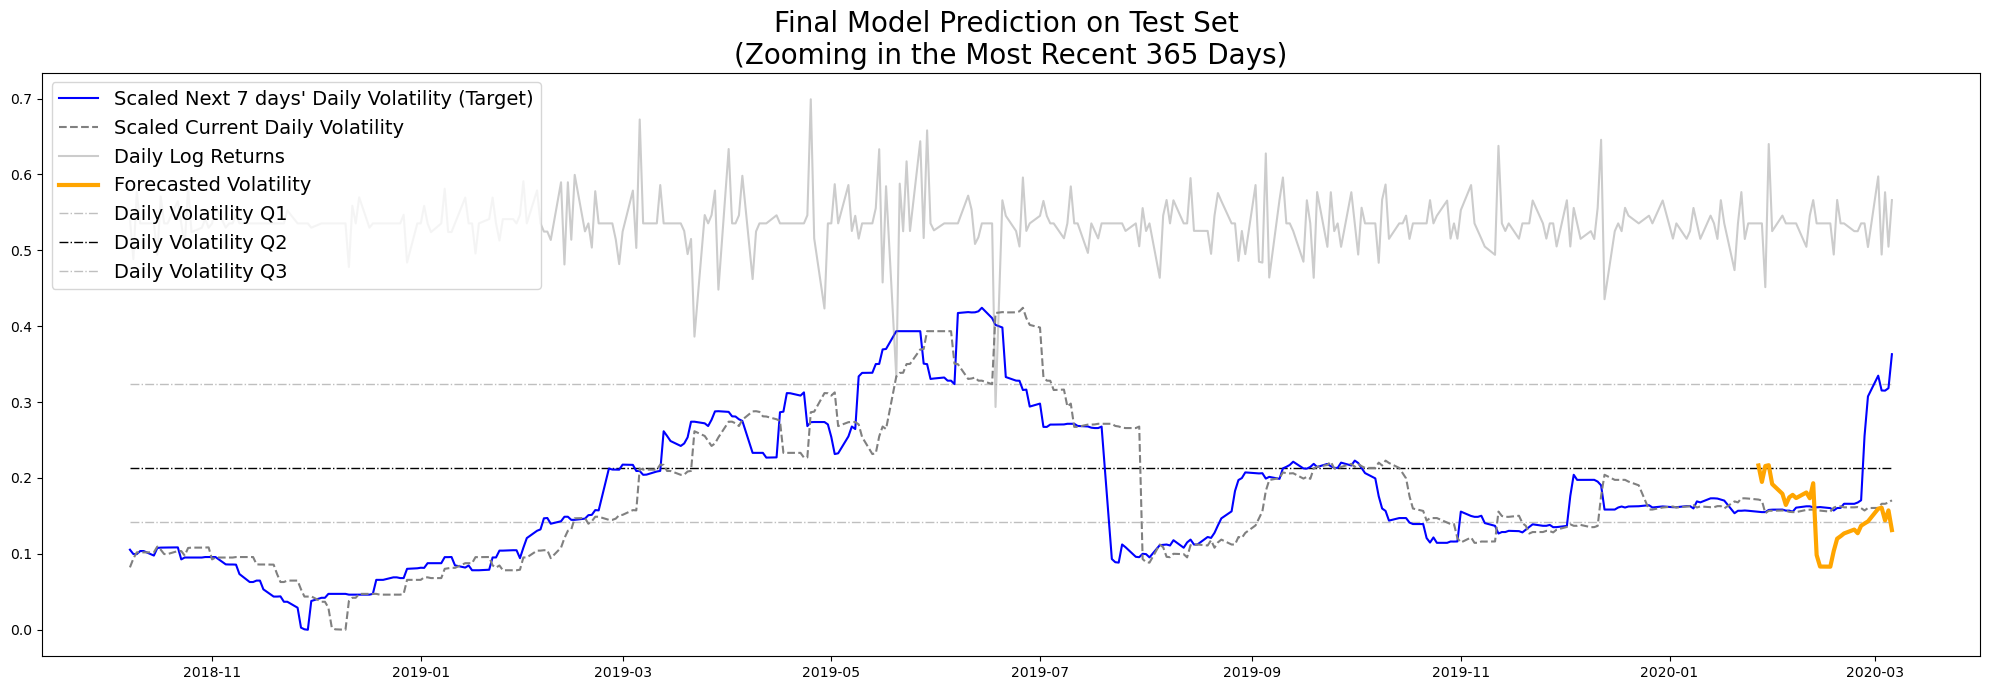

In [136]:
# PLOTTING MODEL PREDICTIONS VS. TARGET VALUES

fig, ax1 = plt.subplots(figsize=(20,7))
# ZOOMING IN THE LAST n_display VALUES
n_display = 365

ax1.plot(df.vol_future[-n_display:], color='blue', 
            label=f"Scaled Next {n_future} days' Daily Volatility (Target)")
ax1.plot(df.vol_current[-n_display:], color='gray',  ls='--',
            label=f"Scaled Current Daily Volatility")
ax1.plot(df.log_returns[-n_display:], color='gray', alpha=0.4,
            label='Daily Log Returns')
ax1.plot(y_test_preds_scaled, color='orange', lw=3,
            label=f'Forecasted Volatility')

ax1.hlines(y=q1, color='gray', alpha=0.5, label='Daily Volatility Q1', ls='-.', lw=1,
           xmin=df.vol_future[-n_display:].index[0],
           xmax=df.vol_future[-n_display:].index[-1])

ax1.hlines(y=q2, color='black', label='Daily Volatility Q2', ls='-.', lw=1,
           xmin=df.vol_future[-n_display:].index[0],
           xmax=df.vol_future[-n_display:].index[-1])

ax1.hlines(y=q3, color='gray', alpha=0.5, label='Daily Volatility Q3', ls='-.', lw=1,
           xmin=df.vol_future[-n_display:].index[0],
           xmax=df.vol_future[-n_display:].index[-1])

# ax2.plot(df.Close[-n_display:])

plt.title(f'Final Model Prediction on Test Set \n(Zooming in the Most Recent {n_display} Days)', fontsize=20)
ax1.legend(loc='upper left', prop={'size': 14})
plt.tight_layout()
plt.savefig(os.path.join('final_lstm_test_preds.jpg'), dpi=300, bbox_inches='tight')
plt.show();

In [137]:
# FINAL MODEL'S RMSPE ON TEST DATA
RMSPE(y_test_scaled, y_test_preds_scaled)

0.35069300186591235

In [138]:
# FINAL MODEL'S RMSE ON TEST DATA
RMSE(y_test_scaled, y_test_preds_scaled)

0.09053088445437084

In [139]:
# MAKING PREDICTIONS ON THE WHOLE DATASET
idx = df.index
forecast = []

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(n_past-1, len(input_df)):
    # GET THE DATA AT THE PREVIOUS n_past TIME STEPS
    # (including current value)
    from_idx = idx[i - n_past + 1]
    to_idx = idx[i]
    pred = lstm_final.predict(input_df[from_idx:to_idx].values[np.newaxis])
    forecast.append(pred)

forecast = np.array(forecast)[:, 0, 0]
y_preds = pd.Series(forecast, index=input_df.index[n_past-1:])

In [140]:
# TRANSFORM PREDICTIONS
y_preds_scaled = pd.Series(final_scaler.transform(y_preds.values.reshape(-1,1))[:,0],
                           index=input_df.index[n_past-1:])

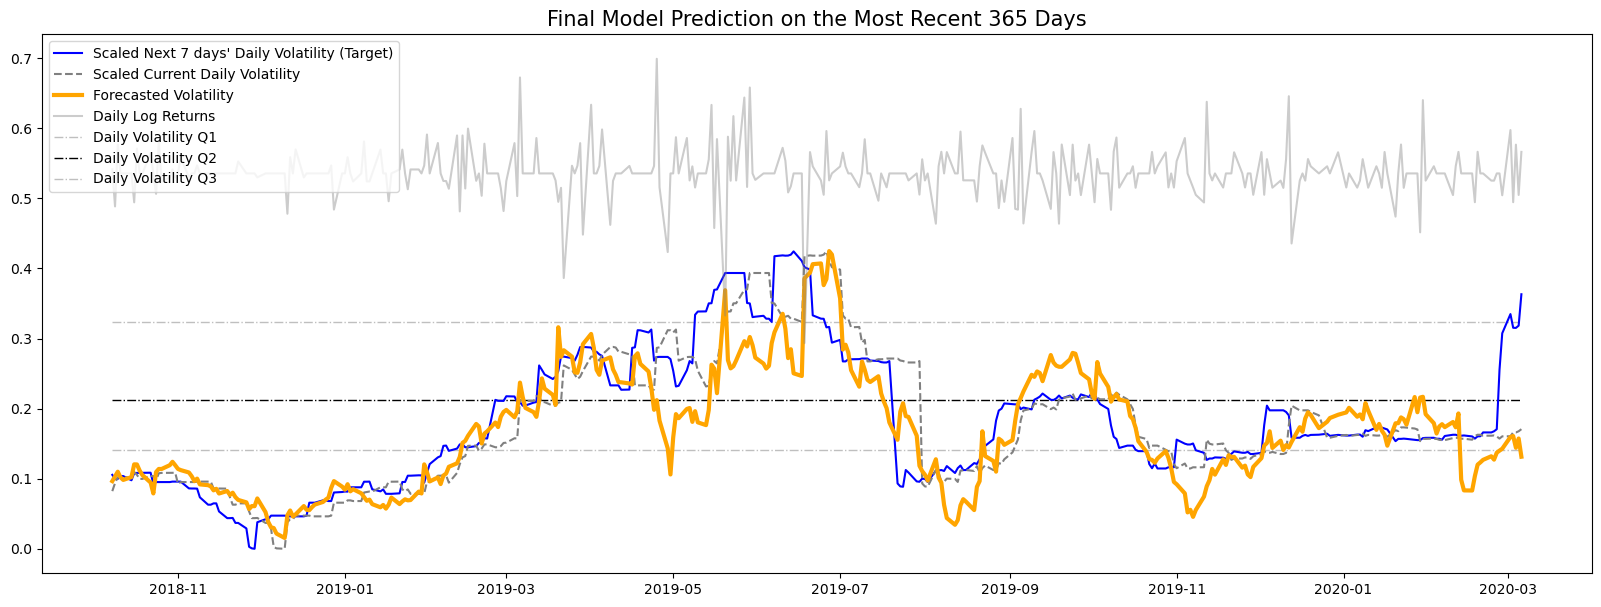

In [141]:
# PLOTTING MODEL PREDICTIONS VS. TARGET VALUES
# ZOOMING IN THE LAST n_display VALUES
n_display = 365

plt.figure(figsize=(20,7))
plt.plot(df.vol_future[-n_display:], color='blue', 
            label=f"Scaled Next {n_future} days' Daily Volatility (Target)")
plt.plot(df.vol_current[-n_display:], color='gray',  ls='--',
            label=f"Scaled Current Daily Volatility")
plt.plot(y_preds_scaled[-n_display:], color='orange', lw=3,
            label=f'Forecasted Volatility')

plt.hlines(y=q1, color='gray', alpha=0.5, label='Daily Volatility Q1', ls='-.', lw=1,
           xmin=vol_future_scaled[-n_display:].index[0],
           xmax=vol_future_scaled[-n_display:].index[-1])

plt.hlines(y=q2, color='black', label='Daily Volatility Q2', ls='-.', lw=1,
           xmin=vol_future_scaled[-n_display:].index[0],
           xmax=vol_future_scaled[-n_display:].index[-1])

plt.hlines(y=q3, color='gray', alpha=0.5, label='Daily Volatility Q3', ls='-.', lw=1,
           xmin=vol_future_scaled[-n_display:].index[0],
           xmax=vol_future_scaled[-n_display:].index[-1])

plt.plot(df.log_returns[-n_display:], color='gray', alpha=0.4,
            label='Daily Log Returns')

plt.title(f'Final Model Prediction on the Most Recent {n_display} Days', fontsize=15)
plt.legend(loc='upper left')
plt.savefig(os.path.join('final_lstm_preds.jpg'), dpi=300, bbox_inches='tight')

plt.show();

In [142]:
perf_df

Model  \
0                                                             Mean Baseline   
1                                             Random Walk Naive Forecasting   
2                                  GARCH(1,1) | Constant Mean | Normal Dist   
3                                         LSTM 1 layer 20 units | n_past=14   
4                          2 layers Bidirect LSTM (32/16 units) | n_past=30   
5          Multivariate Bidirect LSTM 3 layers (64/32/16 units) | n_past=30   
6  Multivariate 2 Bidirect LSTM layers (20/10 units) | n_past=30 | batch=32   

   Validation RMSPE  Validation RMSE  
0         28.954222         0.137538  
1          4.742650         0.044705  
2          4.243133         0.135375  
3          8.020711         0.047053  
4          5.731809         0.041381  
5         11.037557         0.065400  
6          6.894590         0.047439

In [143]:
perf_df.to_pickle("performance_df.pkl")

In [144]:
test_idx

DatetimeIndex(['2020-01-27', '2020-01-28', '2020-01-29', '2020-01-30',
               '2020-01-31', '2020-02-03', '2020-02-04', '2020-02-05',
               '2020-02-06', '2020-02-07', '2020-02-10', '2020-02-11',
               '2020-02-12', '2020-02-13', '2020-02-14', '2020-02-17',
               '2020-02-18', '2020-02-19', '2020-02-20', '2020-02-21',
               '2020-02-24', '2020-02-25', '2020-02-26', '2020-02-27',
               '2020-02-28', '2020-03-02', '2020-03-03', '2020-03-04',
               '2020-03-05', '2020-03-06'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [145]:
df['returns']

Date
2014-02-17    0.405555
2014-02-18    0.480182
2014-02-19    0.480182
2014-02-20    0.491206
2014-02-21    0.496638
                ...   
2020-03-02    0.543404
2020-03-03    0.439178
2020-03-04    0.521942
2020-03-05    0.449429
2020-03-06    0.511358
Name: returns, Length: 1524, dtype: float64

In [146]:
dfdf=df.tail(30)

In [147]:
dfdf1=dfdf['returns']

In [148]:
dfdf1.describe()

count    30.000000
mean      0.481462
std       0.034208
min       0.397045
25%       0.469884
50%       0.480182
75%       0.487941
max       0.588062
Name: returns, dtype: float64

In [149]:
## mean DVLA 0.4693